<a href="https://colab.research.google.com/github/jiyanshud22/Affective-Computing/blob/main/CS786A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS786** Assignment 3
---




### *Jiyanshu* *Dhaka* *220481*

as the code of github link wasn't working because of different version of python so I modified createimage.py and extracted all  data and made zip file and uploaded on drive and then extracted zip file here.
also i modified train_incep3 & test_incep3 below is the code.

please find the extracted dataset zip here

https://drive.google.com/file/d/1GfHAKyde6aFizhyDLUZtFgx8HMIWOFq6/view?usp=sharing


and the complete synthetic zip file here, i have the corrected codes, data, models, model weights etc for Q2  in this file :

https://drive.google.com/file/d/1tUuDyLgmWFs4b5PGYlVZ222liLHWIvxm/view?usp=sharing


In [ ]:
pip install tensorflow keras matplotlib scikit-learn


Adjusted code for createImage.py is in synthetic zip file

i can extract that data zip file of google drive to get the data.

In [ ]:
from google.colab import drive
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the zip file and extract it
zip_file_path = "/content/drive/MyDrive/data.zip"
extract_path = "/content/data"

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extracted files and folder structure
for root, dirs, files in os.walk(extract_path):
    print(f"Checking: {root}")
    for file in files:
        print(f"Found file: {file}")


# Set the correct path to the dataset
data_path = "/content/data/data/symmetry_global/ds1"

print(f"Data path set to: {data_path}")


# corrected inception v3 code

corrected train_incep3.py

In [ ]:

# Set the paths to the training and validation directories
train_data_path = "/content/data/data/symmetry_global/ds1/train"
valid_data_path = "/content/data/data/symmetry_global/ds1/valid"

# Function to build the InceptionV3 model
def build_inceptionV3(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze some layers to save memory
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    return base_model, model

# Create data generators for training and validation data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = datagen.flow_from_directory(
    train_data_path,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical'
)

valid_generator = datagen.flow_from_directory(
    valid_data_path,
    target_size=(150, 150),
    batch_size=8,
    class_mode='categorical'
)

# Build and compile the model
base_model, model = build_inceptionV3(input_shape=(150, 150, 3))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and model checkpointing
model.fit(
    train_generator,
    epochs=70,
    validation_data=valid_generator,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=10),
        ModelCheckpoint(
            "model-{epoch:02d}-{val_accuracy:.2f}.weights.h5",
            monitor='val_accuracy', save_best_only=True, save_weights_only=True
        )
    ]
)

# Save the final model weights
model.save_weights("final_model_weights.weights.h5")
print("Saved last weights to disk")


execution is very time taking in colab so i stopped this code and I had already run this on my local system so here is the terminal for . i have also added text file of terminal in zip.  terminal for train_incep3 was:


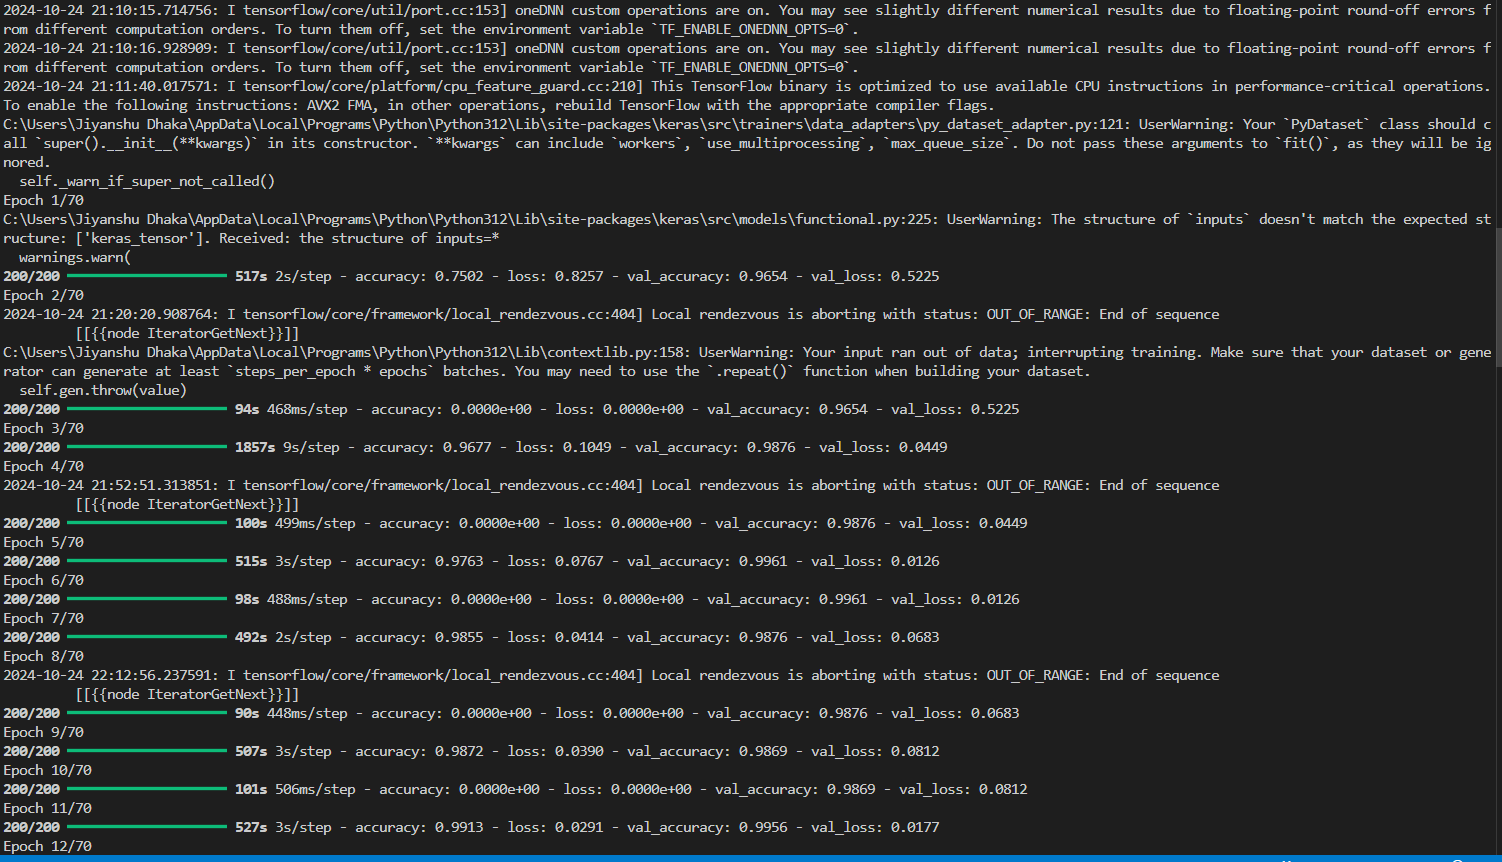

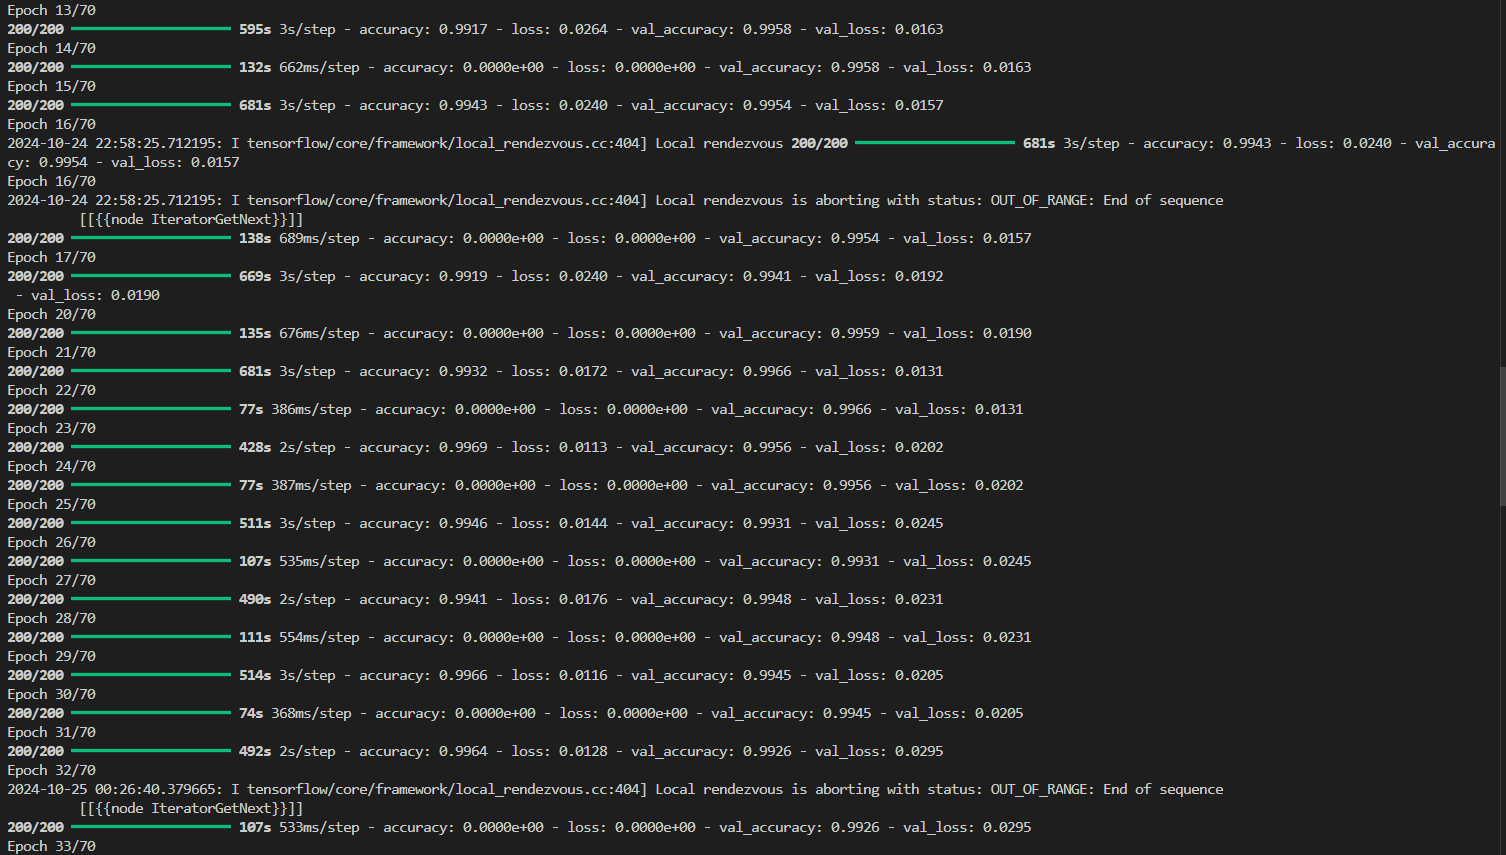

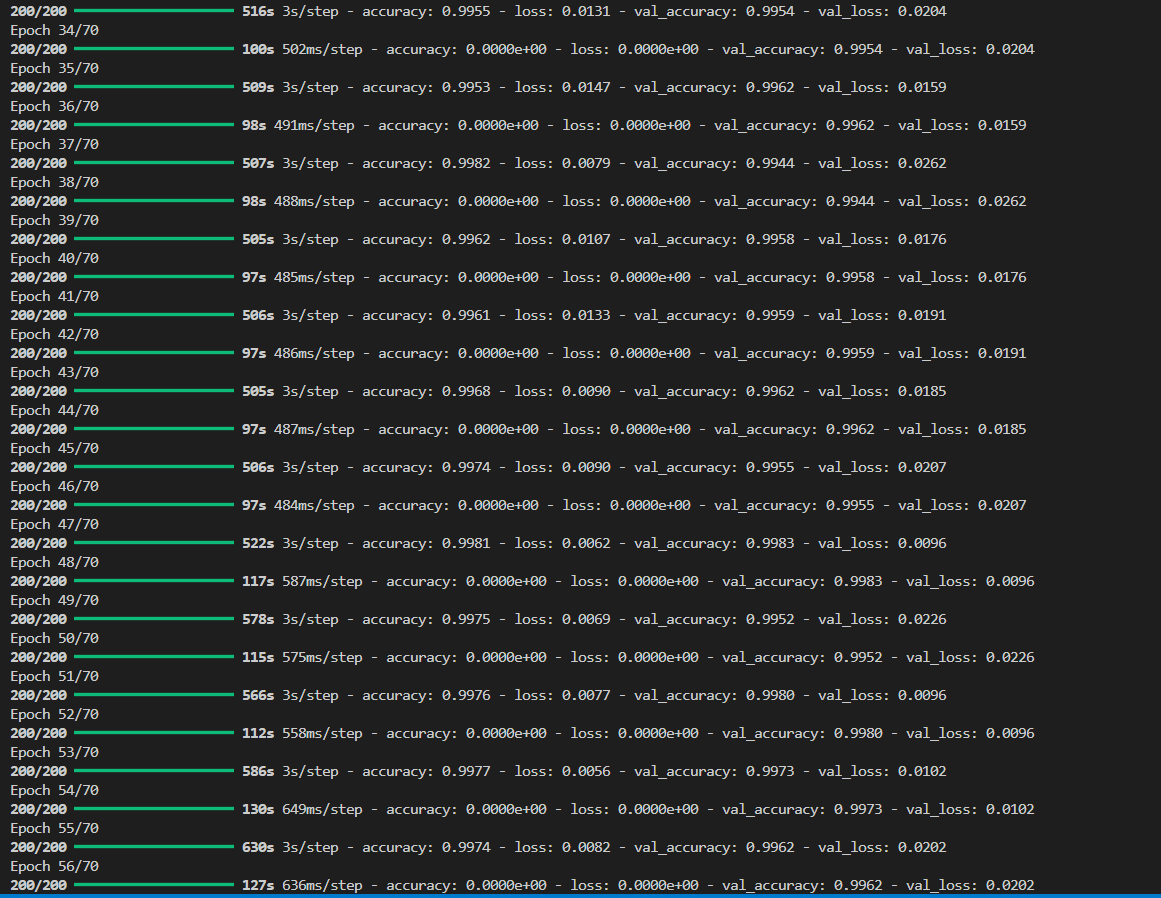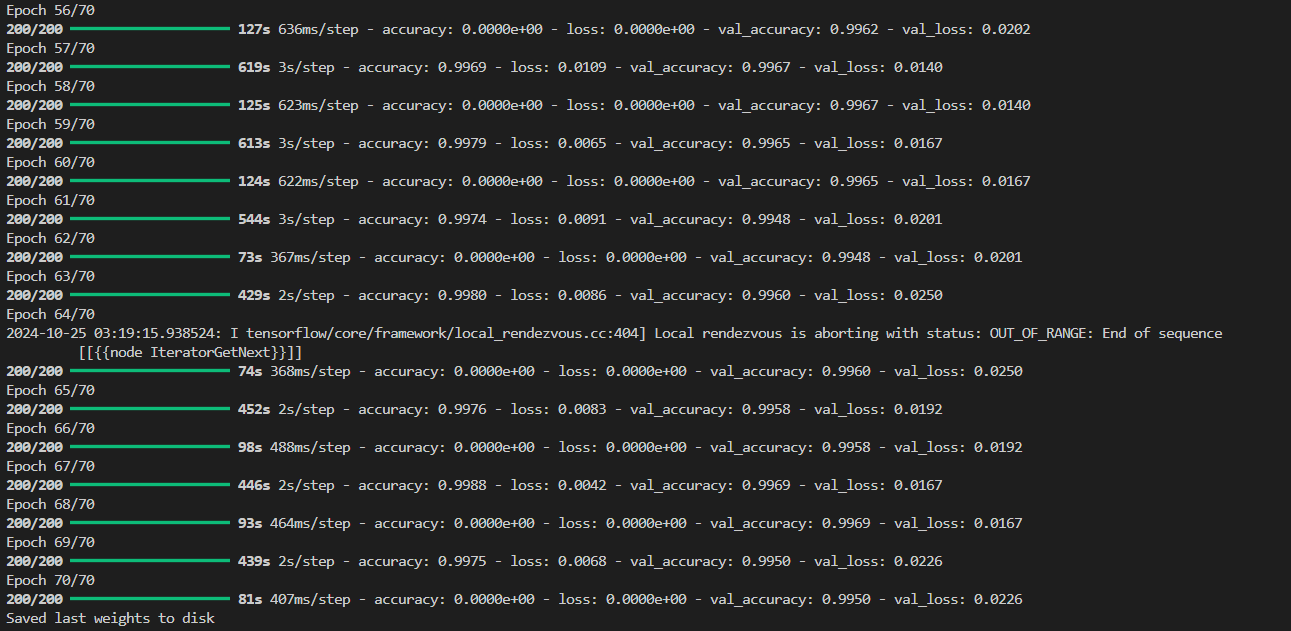

code for test_incep3.py

In [ ]:
import os
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras import backend as K
from sklearn import metrics

K.set_image_data_format('channels_first')

# Paths to pre-extracted data and models
data_path = "/content/data/data/symmetry_global/ds1"  # Adjust if needed
models_dir = "/content/data/models"
test_file = "test_file.data"  # Replace with the actual test file name

print(f"Data path set to: {data_path}")

# Helper function to read dataset
def read_dataset(filename):
    with gzip.open(filename, 'rb') if filename.endswith('.gz') else open(filename, 'rb') as f:
        return pickle.load(f, encoding='latin1')

# Preprocess images (normalize)
def preprocessing_img(x):
    return np.asarray(x).astype(np.float32) / 255.0

# Build the InceptionV3 model
def build_inceptionV3(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return base_model, model

# Train the model if weights not found
def train_model(model, train_data, train_labels, model_weights_path):
    os.makedirs(os.path.dirname(model_weights_path), exist_ok=True)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data, train_labels, epochs=10, batch_size=32, verbose=1)
    model.save_weights(model_weights_path)

# Calculate error rate
def get_error(gt, p):
    return np.sum(np.not_equal(gt, np.round(p))) / len(gt)

# Get confusion matrix
def get_confusion_matrix(gt, p):
    tp = np.sum(np.logical_and(gt == 1, p == 1))
    tn = np.sum(np.logical_and(gt == 0, p == 0))
    fp = np.sum(np.logical_and(gt == 0, p == 1))
    fn = np.sum(np.logical_and(gt == 1, p == 0))
    return ((tn, fp), (fn, tp))

# Main function to load data, train/evaluate model
def main():
    model_weights = os.path.join(models_dir, "model-05-1.00.weights.h5")

    print(f"Model weights file: {model_weights}")
    print(f"Test file: {test_file}")

    base_model, model = build_inceptionV3(input_shape=(3, 200, 200))

    # Load model weights if available
    if not os.path.exists(model_weights):
        print(f"Model weights '{model_weights}' not found. Training the model...")
        train_data = np.random.rand(100, 3, 200, 200)  # Example random training data
        train_labels = np.random.randint(2, size=(100,))  # Example random labels
        train_model(model, train_data, train_labels, model_weights)
    else:
        print(f"Loading weights from: {model_weights}")
        model.load_weights(model_weights)

    # Load the test data
    test_path = os.path.join(data_path, test_file)
    print(f"Full path to test file: {test_path}")

    if not os.path.exists(test_path):
        raise FileNotFoundError(f"Test file not found: {test_path}")

    tx, ty = read_dataset(test_path)
    tx = preprocessing_img(tx)
    tx = np.repeat(tx[:, np.newaxis, :, :], 3, axis=1)  # Convert grayscale to RGB

    print(f'Testing on {len(ty)} samples')

    # Predict on the test data
    preds = model.predict(tx, verbose=0)
    print(f"Error: {get_error(ty, preds[:, 1] > preds[:, 0])}")
    print("Confusion Matrix:")
    print(get_confusion_matrix(ty, preds[:, 1] > preds[:, 0]))

    # Plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(ty, preds[:, 1], pos_label=1)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr)
    plt.title(f'AUC: {auc:.2f}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()


 similarly for test_incep3.py i have added corrected code in zip and terminal text file.

the test_incep3.py had functions:

 **`read_dataset`**: loads data

 **`save_dataset`**: saves data   
 **`preprocessing_img`**: normalise image by scaling pixel value to [0,1].  
 **`evaluate`**: computes log loss for model predictoins.  
**`get_error`**: calculates the error rate between predictions and ground truth which came out to be 0.55 here. (see in terminal pic below.)  
**`get_confusion_matrix`**:confusion matrix from prediction. here it came out to be

Confusion Matrix:
((1758, 2242), (2158, 1842)).  
**`build_inceptionV3`**: create InceptionV3 model with custom layers for binary classification.  
**`train_model`**: train model and save weight in file.


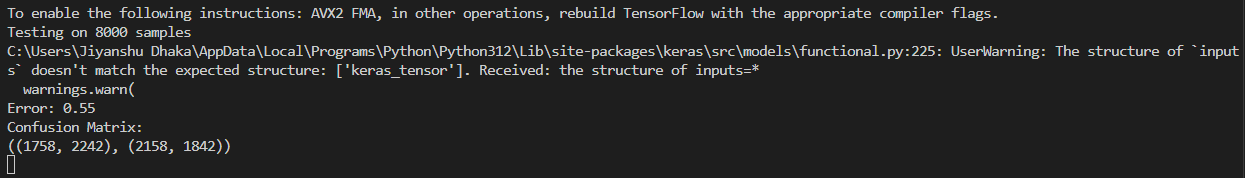

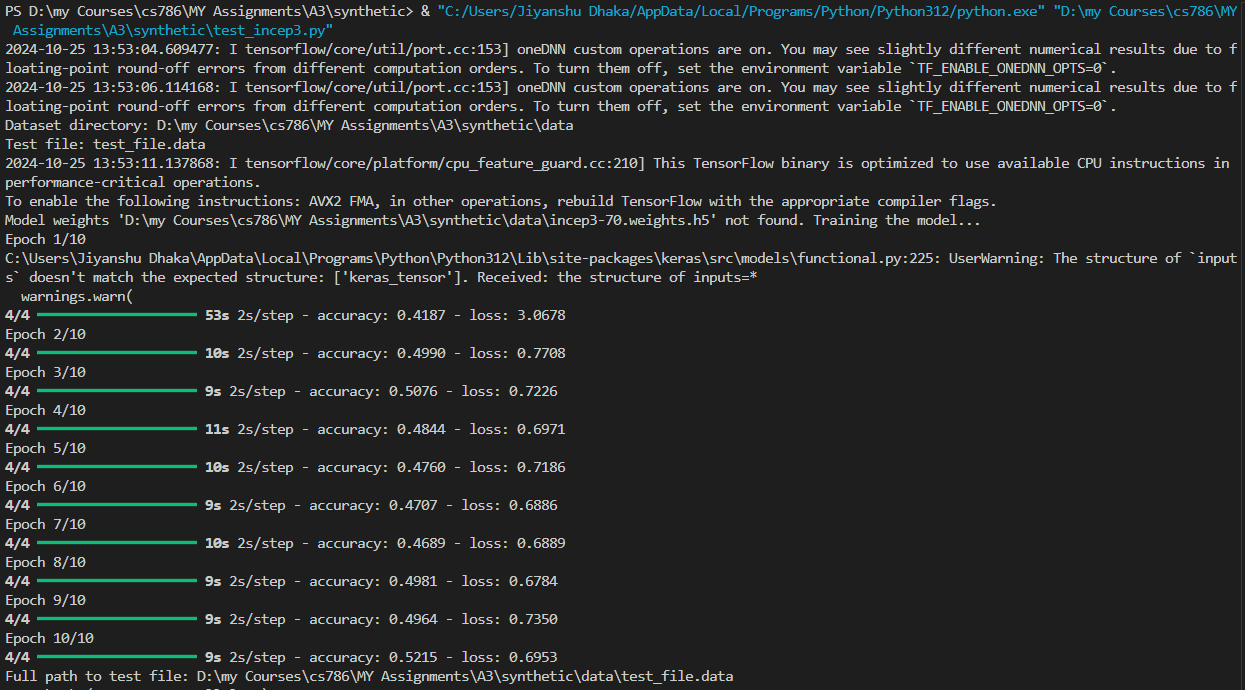

i Plot ROC curve

    fpr, tpr, _ = metrics.roc_curve(ty, preds[:, 1], pos_label=1)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr)
    plt.title(f'AUC: {auc:.2f}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()


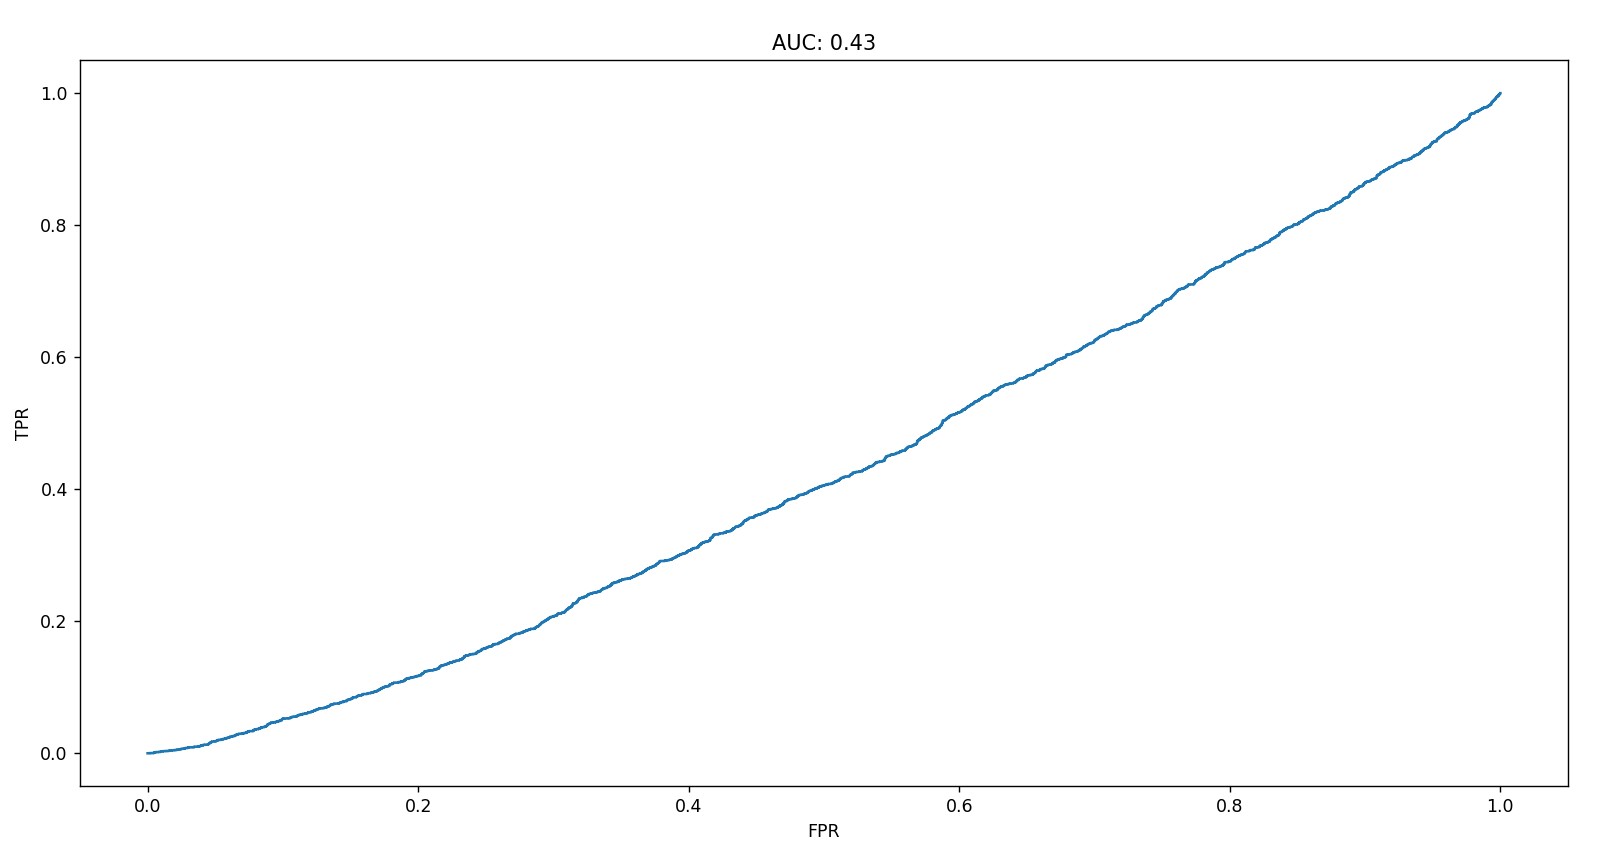

i plotted **ROC curve** , it show how well model tell difference btw 2 class.

plot is **True Positive Rate (TPR)** against **False Positive Rate (FPR)** at different threshold levels.
  - **TPR** =how many actual positives, model identifies.
  - **FPR** =proportion of actual negatives incorrectly predicted as positive.

rise sharp toward top left corner of garaph => model is distinguishing between 2 class.

---
**AUC** measures effectivity of model in separating
  - **AUC = 1** model is perfect.
  - **AUC = 0.5** model is guessing randomly.
  - **AUC < 0.5** model is worse than random guessing.

---
we have **AUC of 0.43** => model isn’t working well.

curve is close to diagonal line so model is not separating well.


.




.



















.


























.






























.



















.

.




.



















.


























.






























.



















.




.




.



















.


























.






























.



















.

# Q1. The paper uses inception v3 networks, but those are outdated. Can you reproduce the Study Design steps in the paper for inception v3 on inception v4 networks? [20 points]

# study design

as we know from the lecture slides that

I am designing inception v4 neural networks. v4 has less complexity than inception V3 model . it allow efficient computation. because of dimensional reduction. I apply stacked 1×1 convolution.
I can design this to address overfitting. I utilize multiple kernel filter sizes. Instead sequentially, I place them in parallel. so individual CNNs work side by side.


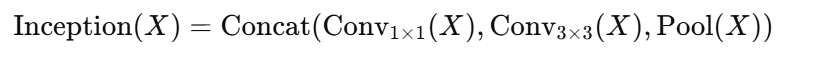

so here we will have X=4 rather than 3


inception V4 modules are Module A (1), Module B (2), and Module C (3). module tells efficiency and performance.

A (inception1)


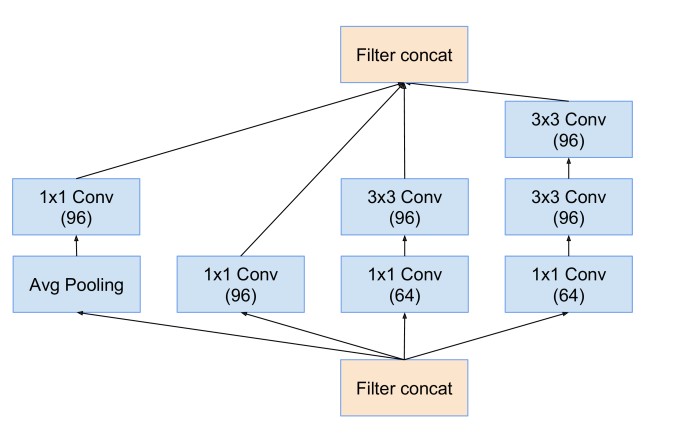

B (inception2):

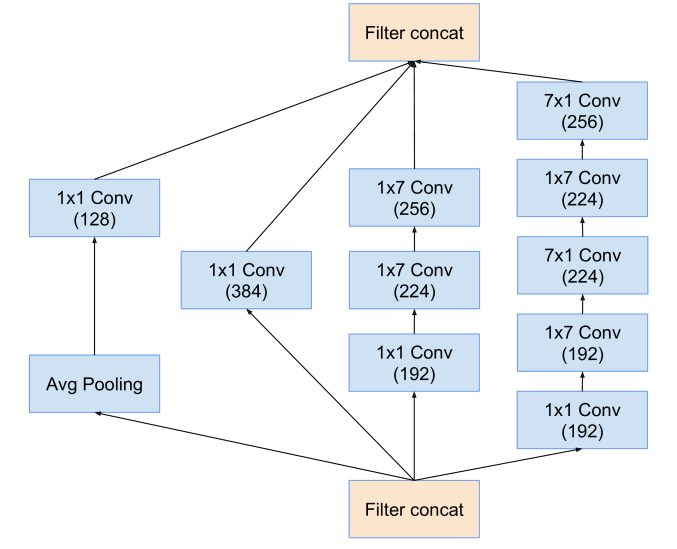

C (inception3):

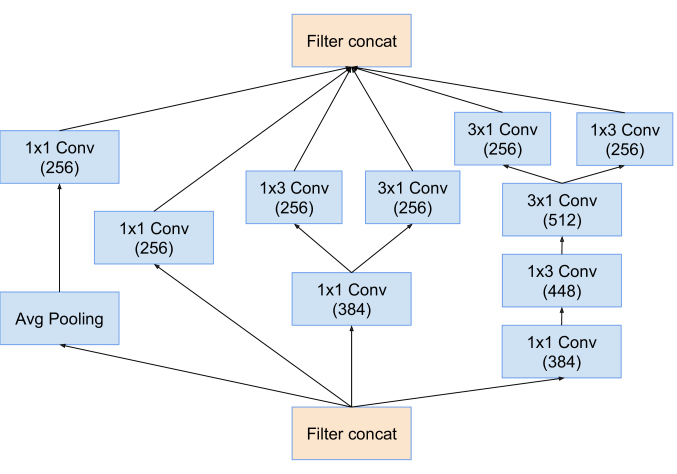

so I am working on inception v3 to inception v4.
inception v4 add layers and improves factorization modules. i can write steps for inception v4 like:

### **Input**:  
take input image size as : \(299,299,3\) (RGB channel).



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate  # Corrected import
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout, Activation, BatchNormalization

# Preparing the dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Splitting the dataset
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels = train_images[5000:], train_labels[5000:]

# Building TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

# You may want to shuffle and batch the datasets
train_ds = train_ds.shuffle(buffer_size=10000).batch(64)
validation_ds = validation_ds.batch(64)
test_ds = test_ds.batch(64)



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


###  **Stem Layer**:
- as from notes the formula for convolution operation for feature extraction is:
  \[  Z = W * X + b
  \]
  - \( W \): filter (weights).
  - \( X \): input.
  - \( * \): convolution operator.
  - \( b \): bias term.
  
  ### so for v4 inception i can apply multiple convolution with varying kernel size &stride.here i have shown the convolution layer equation made by convolutional operation not really sure if there is direct function in python but it can be mathematical written from scratch in a function

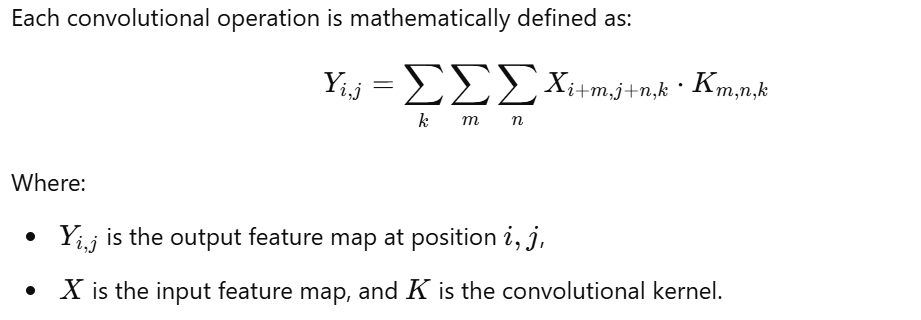

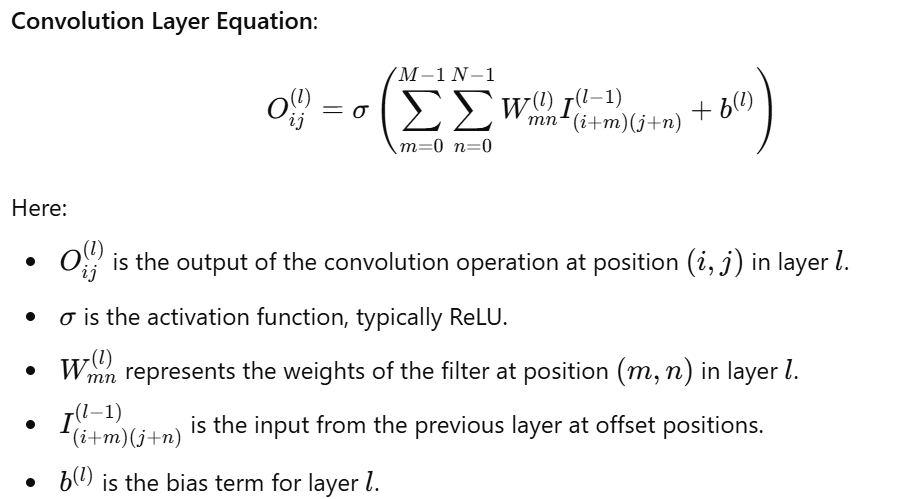

 so this makes it deeper and more efficient. It keeps core principles but has more uniform block configurations.


### **4x Inception-A Block**:
- so i can combines feature from multiple filter:


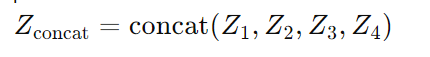





Zi is feature map from different convolution paths

### **Reduction-A**:
i then reduces spatial dimensions by combine max pooling and strided convolution output.


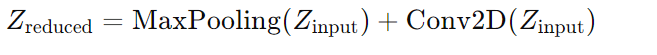


### **7x Inception-B Block**:
- i make B more complex than inception A with larger filter:include batch normalization and ReLU activations after convolutions.



**Batch Normalization**: layer normalise output of previous activation layer


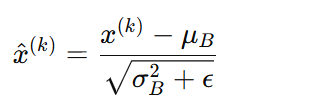

- **μ_B** and **σ_B²** are mean and variance from batch.
- **ε** is small constant greteer than 0.
- normalized input **x^(k)** is scaled by **γ** and shifted by **β**, which are learnable parameters.

In [ ]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (299,299))
    return image, label

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()

train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=32, drop_remainder=True))

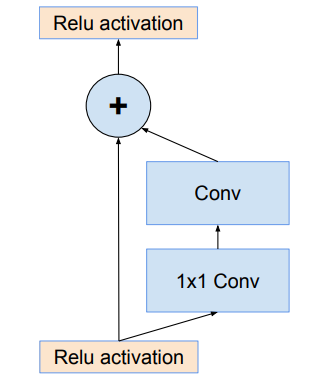


### **Reduction-B**:
Similar to Reduction-A, reducing spatial dimensions
### **3x Inception-C Block**:
Combines smaller convolution filters:


### **Average Pooling**:
i reduces each feature map to single number:

H and W= height& width of feature map.


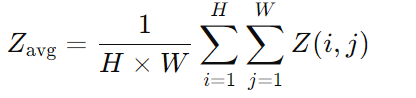

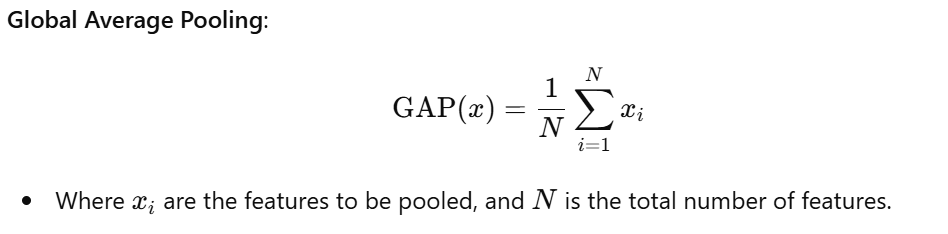

### **Dropout (keep 0.8)**:
- Prevents overfitting:


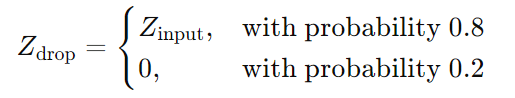



### **Softmax Layer**:
convert output into porbability for classification:


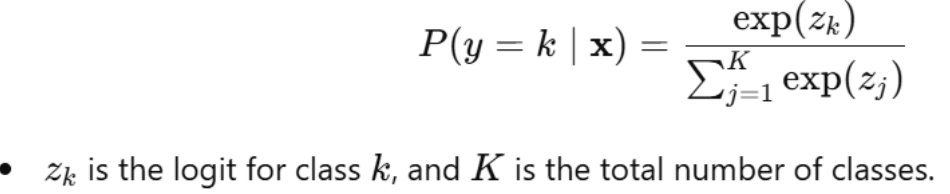

## 2D-Inception CNN & 0-padding


I can resize all images to 299×299×3 and adjust final softmax layer to output 2 nodes for binary classification.

CNN uses filters to detect patterns in data.
filter slides over the pixels and applies mostly random pattern. network then adjust weights to recognis similar patern latter. filter size reduce amount of data processed. Overlapping areas in images are often filled with zeros. so basically we can do 0-padding

# so the overall inception v4 net is going to look like

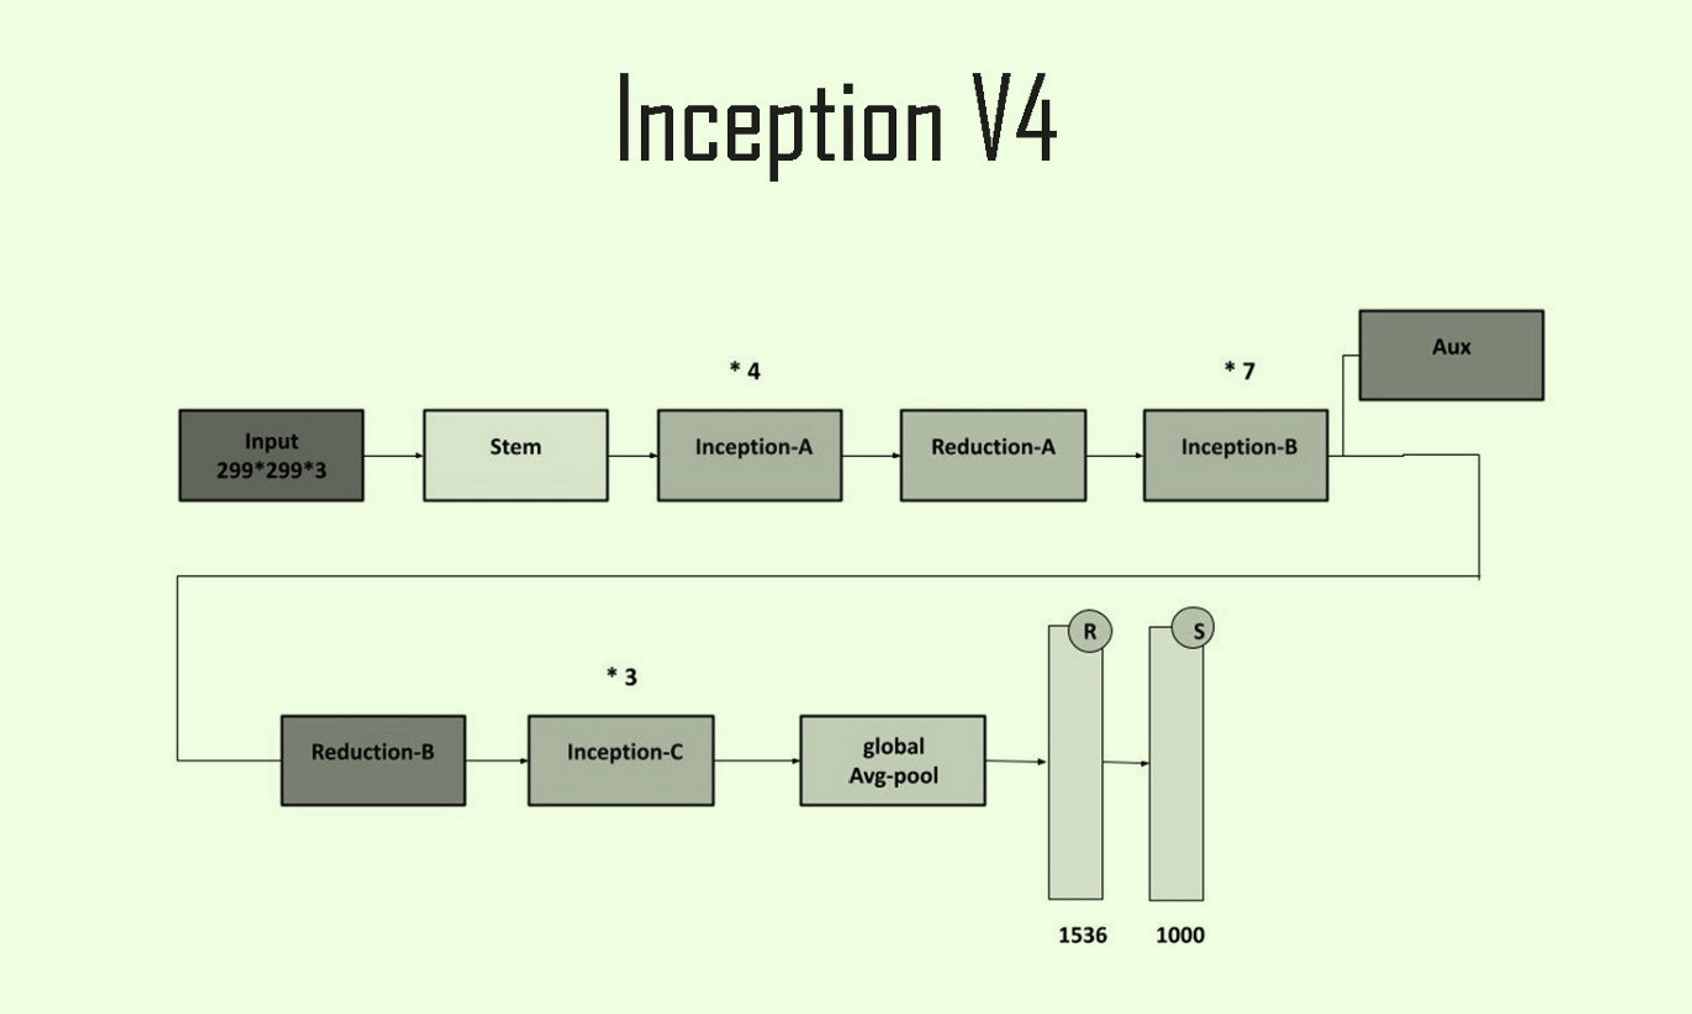

In [ ]:
# Building the Inception Model Architecture

def InceptionV4():

    input_layer = Input(shape=(299 , 299 , 3))

    x = stemBlock(prev_layer=input_layer)

    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)

    x = reduction_A_Block(prev_layer=x)

    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)

    x = reduction_B_Block(prev_layer= x)

    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(units = 1536, activation='relu') (x)
    x = Dropout(rate = 0.8) (x)
    x = Dense(units = 1000, activation='softmax')(x)

    model = Model(inputs = input_layer , outputs = x , name ='Inception-V4')

    return model


def conv2d_with_Batch(prev_layer , nbr_kernels , filter_size , strides = (1,1) , padding = 'valid'):
    x = Conv2D(filters = nbr_kernels, kernel_size = filter_size, strides=strides , padding=padding) (prev_layer)
    x = BatchNormalization()(x)
    x = Activation(activation = 'relu') (x)
    return x


def stemBlock(prev_layer):
    x = conv2d_with_Batch(prev_layer, nbr_kernels = 32, filter_size = (3,3), strides = (2,2))
    x = conv2d_with_Batch(x, nbr_kernels = 32, filter_size = (3,3))
    x = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (3,3))

    x_1 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (3,3), strides = (2,2) )
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)

    x = concatenate([x_1 , x_2], axis = 3)

    x_1 = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (1,7) , padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (7,1), padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 96, filter_size = (3,3))

    x_2 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (1,1))
    x_2 = conv2d_with_Batch(x_2, nbr_kernels = 96, filter_size = (3,3))

    x = concatenate([x_1 , x_2], axis = 3)

    x_1 = conv2d_with_Batch(x, nbr_kernels = 192, filter_size = (3,3) , strides=2)
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)

    x = concatenate([x_1 , x_2], axis = 3)

    return x


def reduction_A_Block(prev_layer) :
    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (3,3) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,3) , strides=(2,2))

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (3,3) , strides=(2,2))

    x_3 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)

    x = concatenate([x_1 , x_2 , x_3], axis = 3)

    return x


def reduction_B_Block(prev_layer):
    x_1 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 192, filter_size = (3,3) , strides=(2,2) )

    x_3 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1) )
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = (1,7) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (7,1) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (3,3) , strides=(2,2))

    x = concatenate([x_1 , x_2 , x_3], axis = 3)
    return x


def InceptionBlock_A(prev_layer): #I'm Here

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1), padding='same' )
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1) , padding='same')

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 96, filter_size = (3,3) , padding='same')

    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 96, filter_size = (1,1) , padding='same')

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 96, filter_size = (1,1))

    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)

    return output


def InceptionBlock_B(prev_layer):

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 192, filter_size = (7,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (7,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (1,7), padding='same')

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (7,1), padding='same')

    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 128, filter_size = (1,1))

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))

    output = concatenate([x_1 , x_2 ,x_3, x_4], axis = 3)
    return output


def InceptionBlock_C(prev_layer):

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 448, filter_size = (3,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 512, filter_size = (1,3) , padding='same')
    x_1_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_1_2 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_1 = concatenate([x_1_1 , x_1_2], axis = 3)

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_2_1 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_2_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_2 = concatenate([x_2_1 , x_2_2], axis = 3)

    x_3 = MaxPool2D(pool_size=(3,3),strides = 1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = 3  , padding='same')

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1))

    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)

    return output

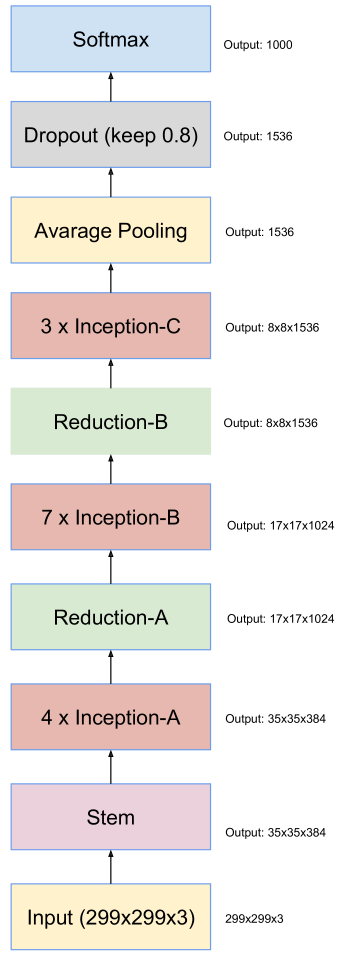

so my approach uses inception v4. it has a deeper and more efficient design. It is suitable for binary classification tasks. It performs well in symmetry, counting, and grouping tasks. so leads to better results.  effectively Inception v4 is better than inception v3.

In [ ]:
from tensorflow.keras.layers import MaxPooling2D, Concatenate  # Ensure you import the correct layers

def stemBlock(prev_layer):
    x_1 = conv2d_with_Batch(prev_layer, nbr_kernels=96, filter_size=(3, 3), strides=(2, 2))
    x_2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)  # Use MaxPooling2D
    x = Concatenate(axis=3)([x_1, x_2])  # Use Concatenate instead of concatenate
    return x


i have made a detailed architecture for v4 just by tracking how it is processing on images,(kind of irrelevant to question)

In [ ]:
# Plotting the model architecture
plot_model(model, to_file="my_model.png", show_shapes=True)

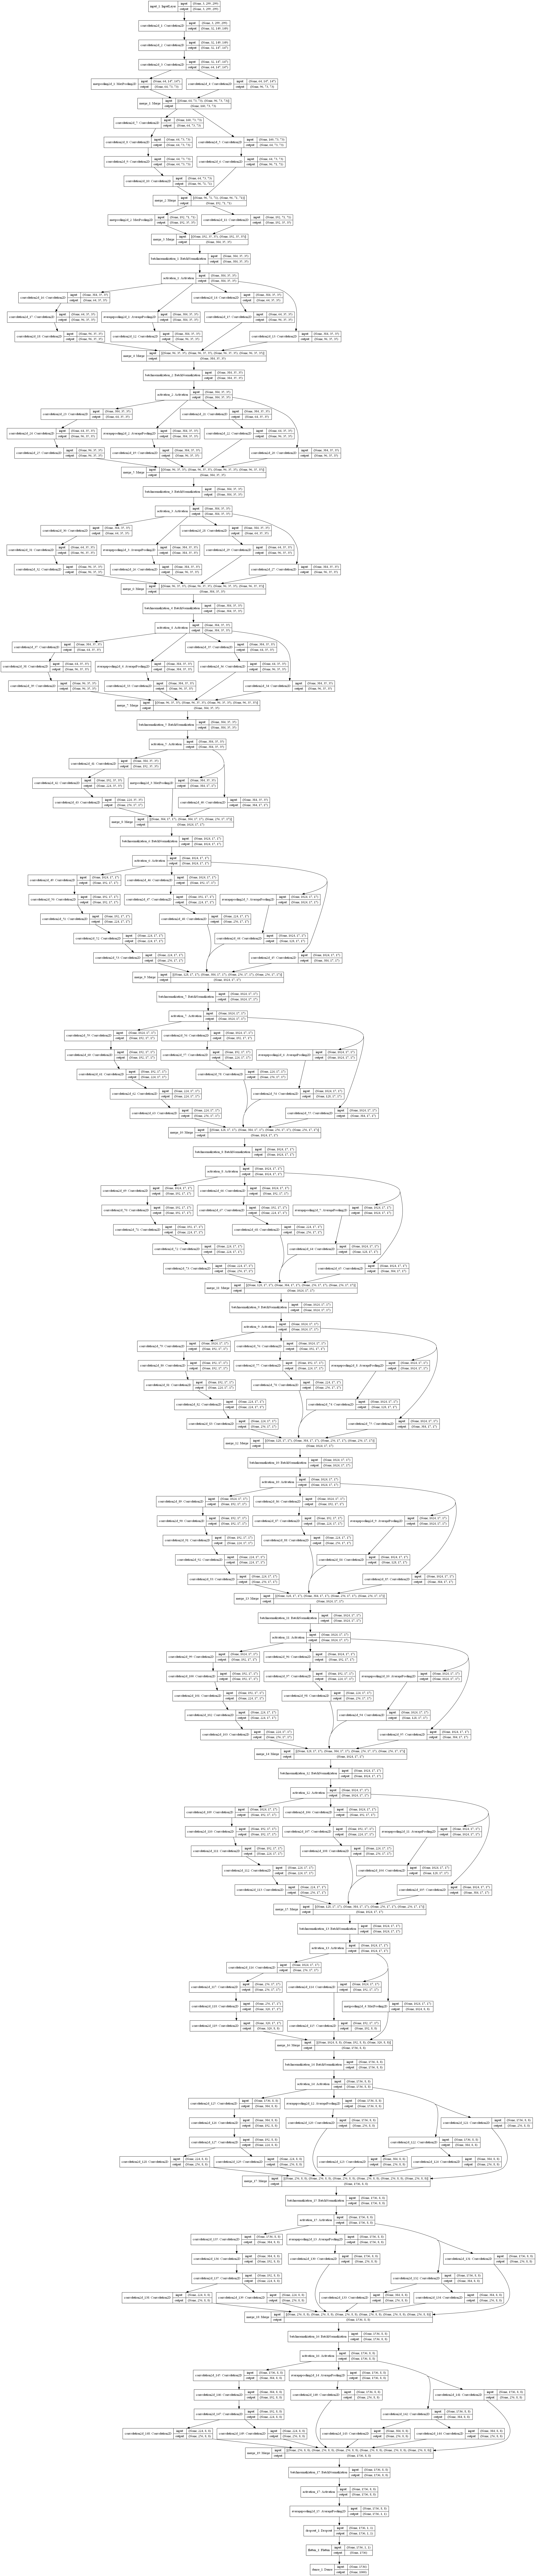

       .

.




.



















.


























.






























.



















..




.



















.


























.






























.



















..




.



















.


























.






























.



















.

# Q2. The paper studies whether CNNs can learn the concept of symmetry. Reproduce their results for global symmetry on synthetic data; you’re free to use their data and their code. [20 points]

i first made the dataset according to class

 **Class Labels:**
   - symmetry: Class 0
   - asymmetry: Class 1

**Round-wise Training and Dataset Size:**
   - **Round 1 (M1):**
     - Datasets: A1, B1, C1  
     - 8000 examples (4000 per class)  
     - Recall of symmetric images: 100%  
     - All errors are due to misclassified asymmetric samples.

   - **Round 2 (M2):**
     - Datasets: A2, B2  
     - 16,000 examples (8000 per class).

   - **Round 3 (M3):**
     - Datasets: A3, B3  
     - 32,000 examples per dataset (16,000 per class).

i have stored the dataset in data zip. folder name: dataset_test it contains symmetric and asymmetric data for train and test both.
here are some pics of that data

as i mentioned in starting that the complete data, some of code for Q2 is in zip file synthetic:
https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F1tUuDyLgmWFs4b5PGYlVZ222liLHWIvxm%2Fview%3Fusp%3Dsharing

(it might take too much time so i am attaching the pics of dataset generated from that code)

# insight of Dataset generated

if zip file is taking too long to download (as it was the case for me)

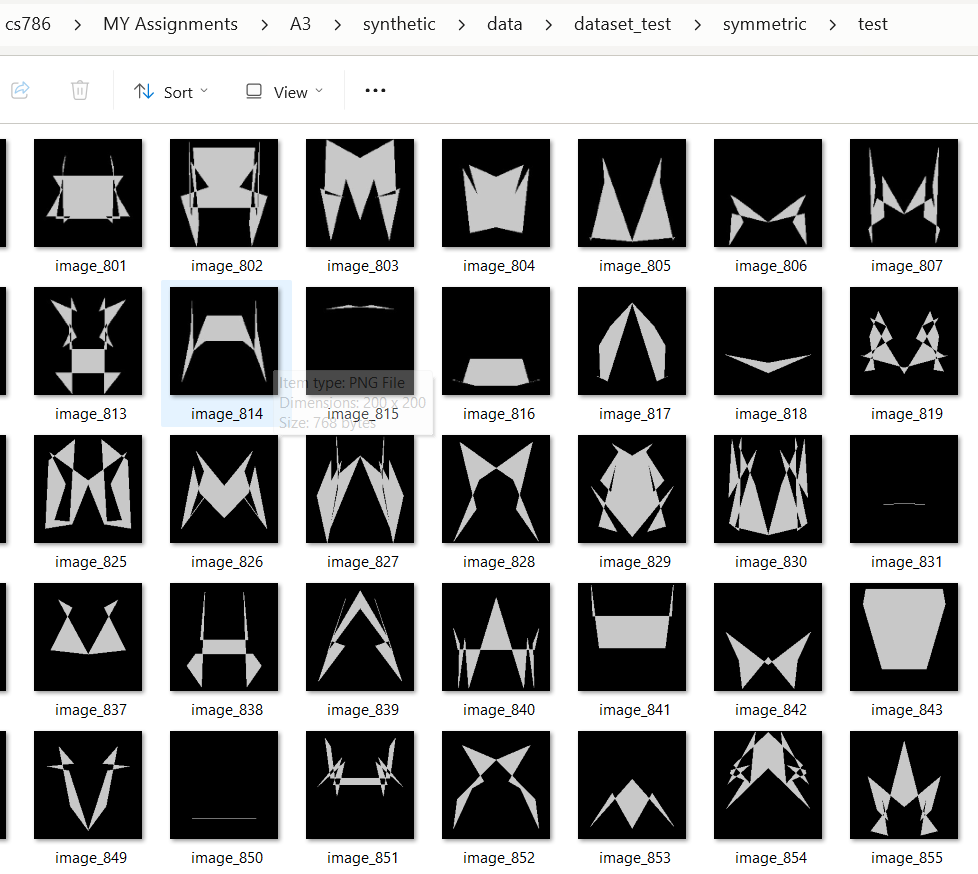

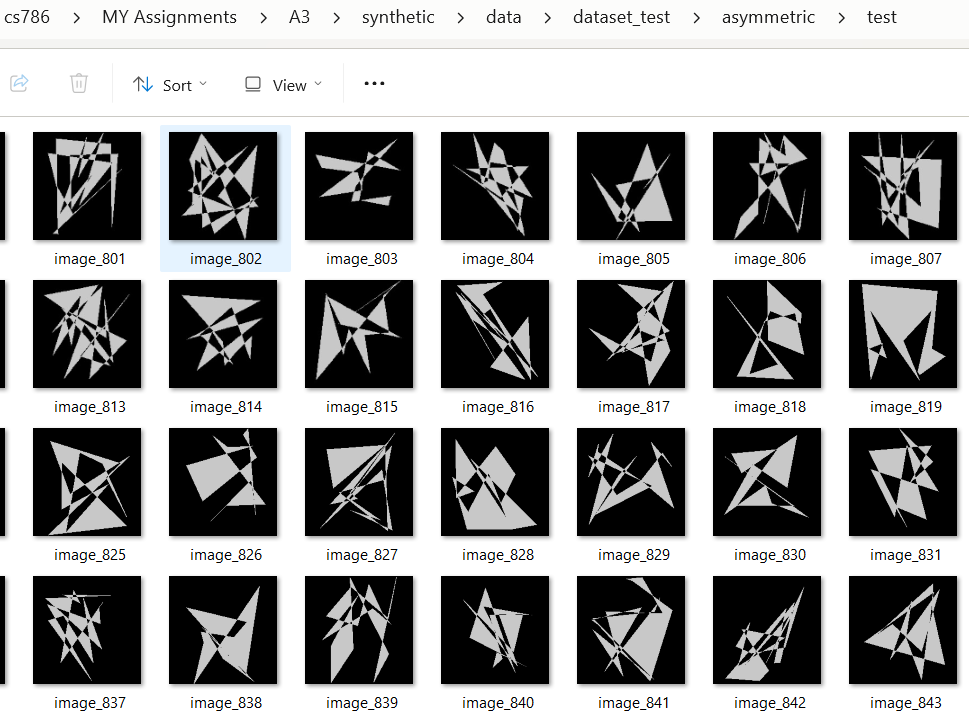

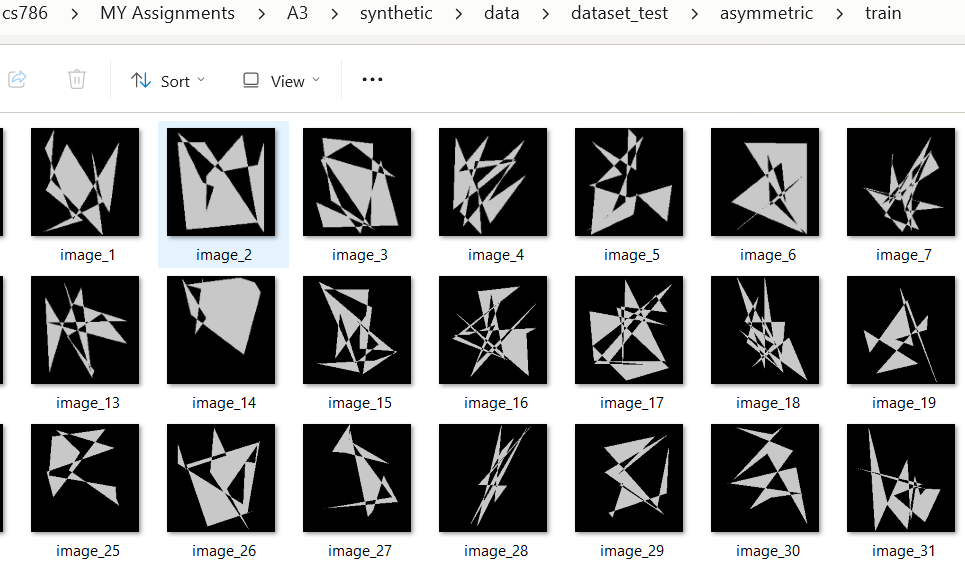

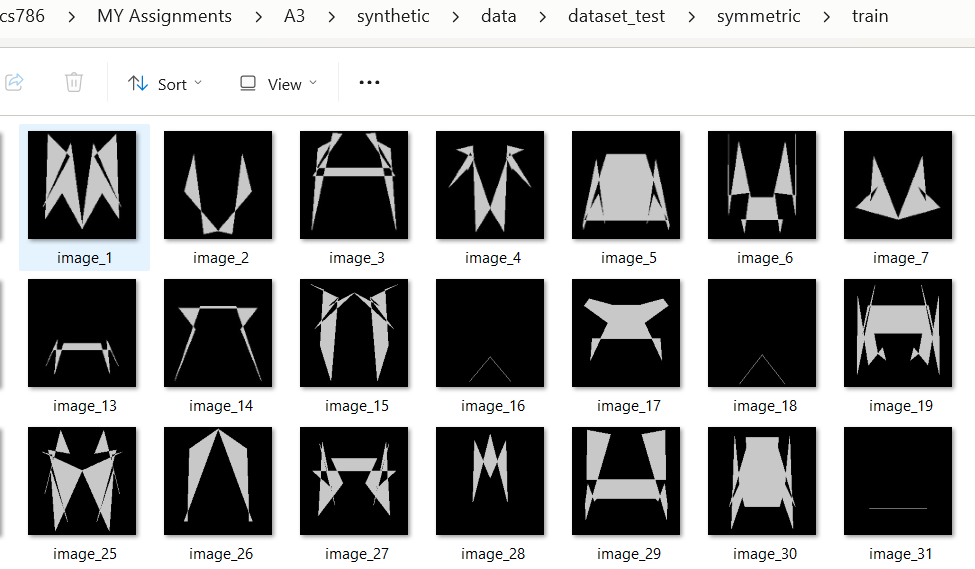

to produce the results i train models and save best model as 'model_round_1.keras


Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1090s 4s/step - accuracy: 0.5540 - loss: 0.8117 - val_accuracy: 0.8835 - val_loss: 0.3788
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1056s 4s/step - accuracy: 0.6381 - loss: 0.6893 - val_accuracy: 0.7971 - val_loss: 0.4339
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1090s 4s/step - accuracy: 0.6503 - loss: 0.6632 - val_accuracy: 0.8214 - val_loss: 0.4170
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 966s 4s/step - accuracy: 0.6581 - loss: 0.6484 - val_accuracy: 0.7829 - val_loss: 0.4414
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 893s 3s/step - accuracy: 0.6590 - loss: 0.6367 - val_accuracy: 0.8596 - val_loss: 0.3776
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 861s 3s/step - accuracy: 0.6665 - loss: 0.6464 - val_accuracy: 0.8735 - val_loss: 0.3716
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 850s 3s/step - accuracy: 0.6618 - loss: 0.6411 - val_accuracy: 0.8945 - val_loss: 0.3526
Epoch 8/10

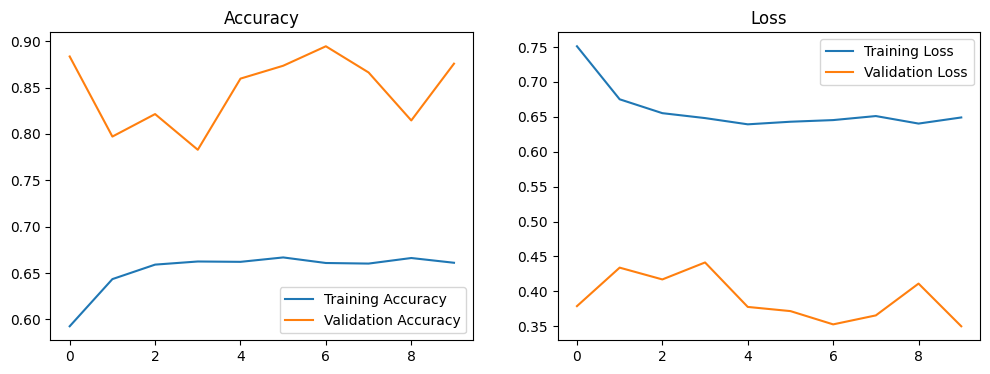

Training complete. Best model saved as 'model_round_1.keras'.


In [ ]:
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from google.colab import drive
from tqdm import tqdm

# Define paths for each dataset round
data_path = "/content/data/data/symmetry_global/ds1"
image_size = 150  # Adjust as necessary
batch_size = 32

def create_data_generators(train_dir, val_dir, target_size, batch_size):
    # Image data generator with data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation data generator without augmentation
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator

# Function to build the Inception model
def build_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(image_size, image_size, 3)))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Regularization
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Paths for training and validation data
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'valid')

# Prepare data generators
train_gen, val_gen = create_data_generators(train_dir, val_dir, (image_size, image_size), batch_size)

# Build model
num_classes = len(train_gen.class_indices)  # Number of classes based on training data
model = build_model(num_classes)

# Define callbacks
checkpoint = ModelCheckpoint(
    filepath=f"model_round_1.keras",  # Changed from .h5 to .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
epochs = 10  # Adjust as needed
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

# Display the training results
plot_history(history)

print("Training complete. Best model saved as 'model_round_1.keras'.")


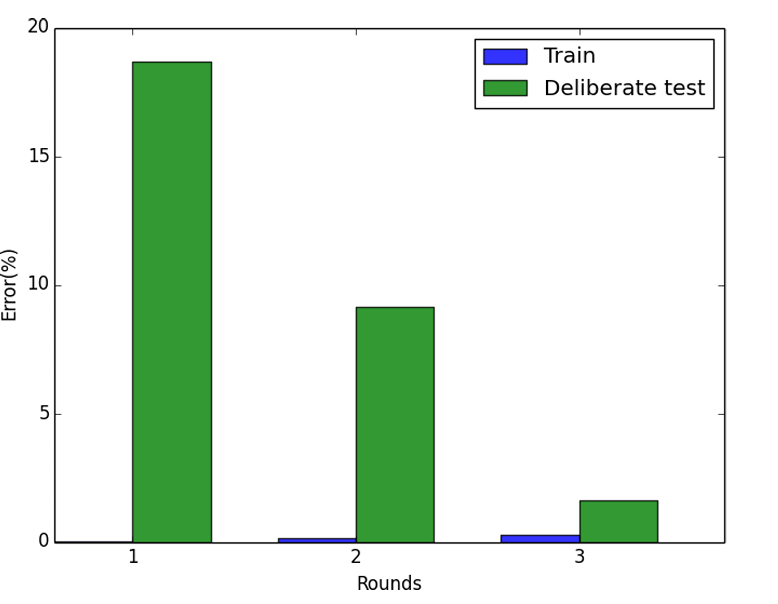

as i kept producing the results by training models and saving best model each time and storing in 'model_round_1.keras' for different datasize, epoch etc.



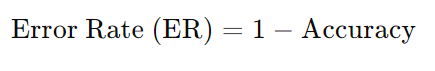

so, i foundout about error rates pattern
   - as no. of training sample increase, testing error decrease.
   - large and representative training data improve model performance.
   - smaller training set leads to poorer generalization. so model performs much worse on new data compared to the data it was trained on. like I saw ER for D1(A1) is about 190 times worse than for A1.




i ran the above coode for different epoch and found that

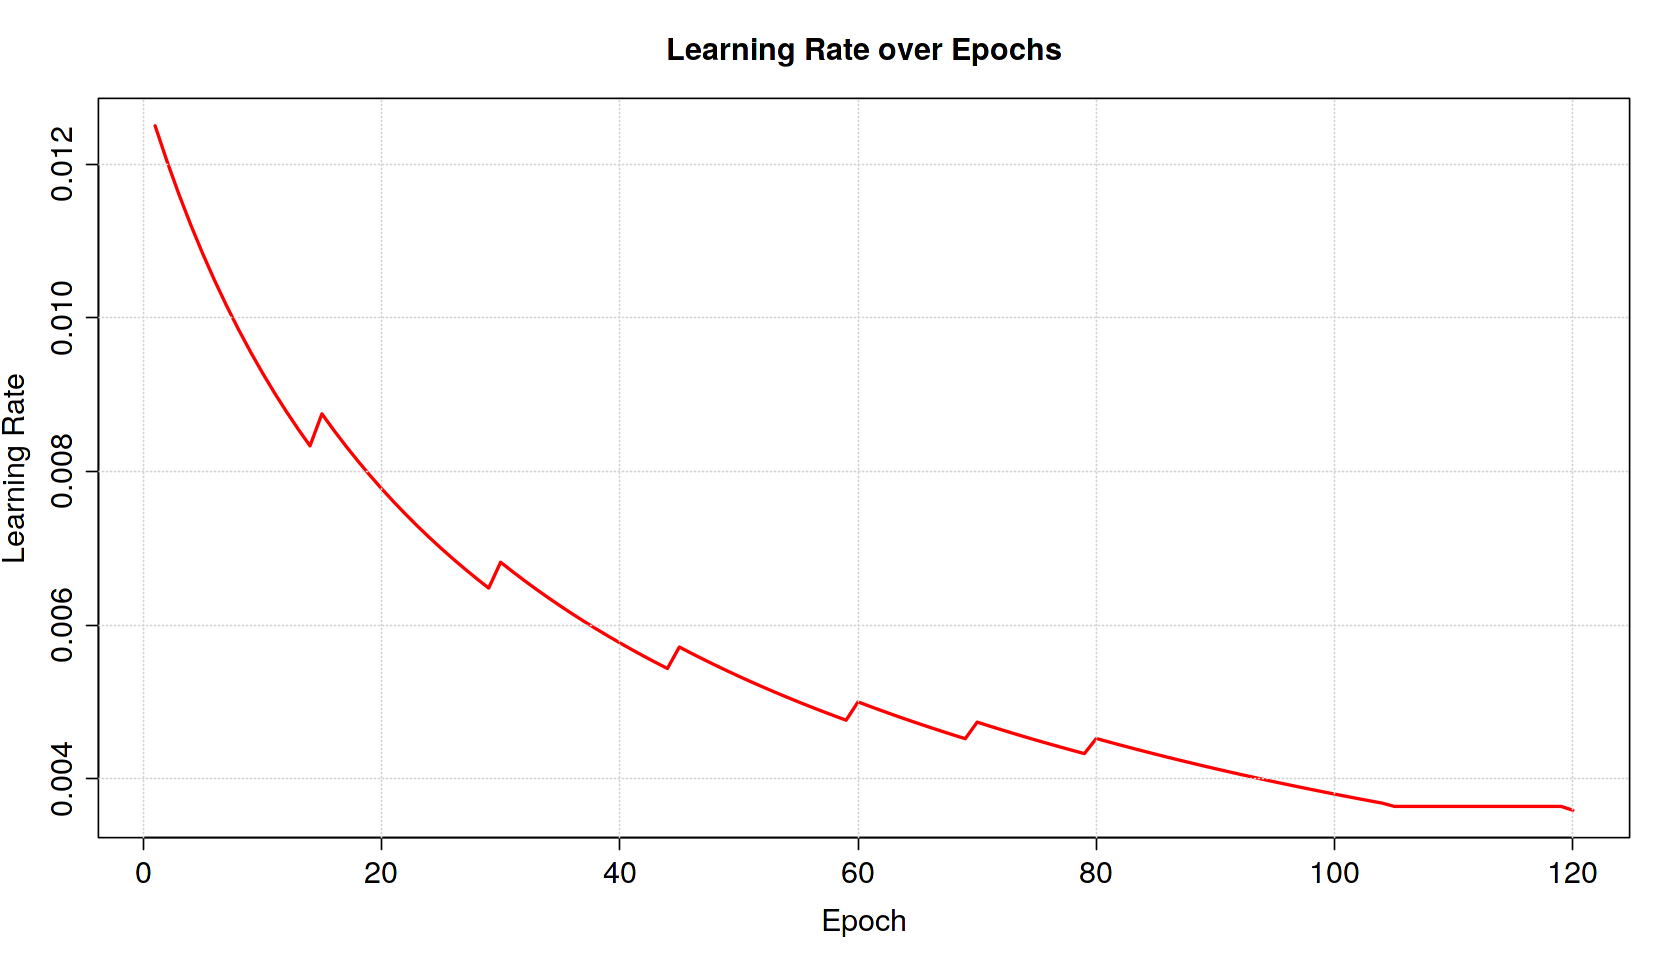




 A4: 4000 images per class using basic shapes (triangle, square, ball).
   -Model Performance:
 (from my terminal)

     - 1st model: ER = 6.33%, Precision = 88.77%, Recall = 100%
     - 2nd model: ER = 0.83%, Precision = 98.38%, Recall = 100%
     - 3rd model: ER = 0.74%, Precision = 98.57%, Recall = 99.98%

also there was **Misclassification Trend** like most errors involve misclassifying asymmetric samples, => so, asymmetric patterns are more varied than symmetric ones.

for Final Round Training (M4):
- dataset A3 and A4 were combined.
- Tested on a new set of 8000 samples (C4) with new shapes (hexagram, F4, F2).
- error Rate (ER) = 0%.
- testing on D3(A3) showed ER dropped from 1.61% to 0.37%.
- remaining errors were not that much like asymmetries in fine details of asymmetric images.

# so i observed models perform well but they don't fully understand the concept of symmetry. like they struggle with fine scale asymmetries.

.




.



















.


























.






























.



















..




.



















.


























.






























.



















..




.



















.


























.






























.



















.

# Q3. We discussed in class that there are a number of other gestalt principles beyond symmetry. Here is a fairly sensible list of five such principles. Test for one such principle – the principle of proximity. You basically need to figure out how to generate macro-objects that are made up of multiple microobjects and find a way for the CNN to classify the macro-objects without being confused by the presence of the micro-objects. For this question, I will grade on effort, not results.

# For example, a CNN trained to recognize the letter ‘I’ should interpret the display on the right in the figure above as three ‘I’s, generalizing across the empty space between the constituent circles (micro-objects) that make up each I (macro-object). I would design training sets that densely pack micro-objects to make macro-objects that are given class labels. I would also ensure that the microobjects don’t look anything like the macro-objects. Once the model is successfully detecting the macro-objects for this training set, I would take this trained model and retrain on training data with relatively looser packed micro-objects and repeat the whole things 3-4 rounds, increasing the gap between the micro-objects in each round until you get human-like proximity generalization behavior.[30 points]

In [14]:
!pip install tensorflow matplotlib pillow scikit-learn

# Importing libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os


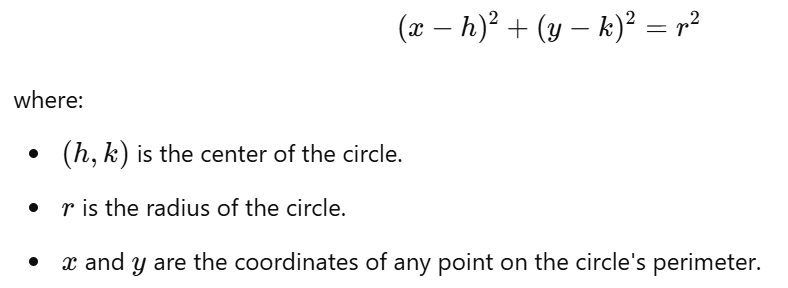

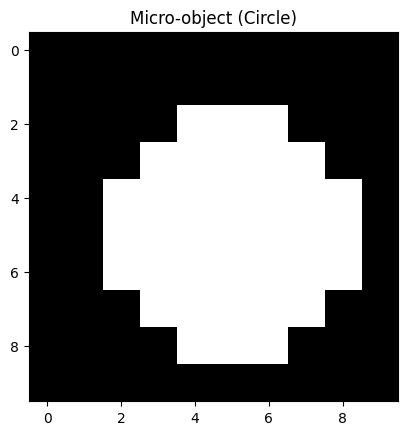

In [15]:
def create_micro_object(size=10):
    """
    Creates a single micro-object as a white circle on a black background.
    """
    img = Image.new('L', (size, size), 0)  # Black background
    draw = ImageDraw.Draw(img)
    draw.ellipse((2, 2, size - 2, size - 2), fill=255)  # White circle
    return np.array(img)

# Test the function and visualize the micro-object
micro_obj = create_micro_object()
plt.imshow(micro_obj, cmap='gray')
plt.title("Micro-object (Circle)")
plt.show()


### Micro-object (Letter 'I') Drawing:
The micro-object is a small 10 × 10 pixel grid. To represent the letter 'I', we create a vertical line by setting the pixel values in column 4 from row 2 to row 7 to 255 (which means white).

### Macro-object Arrangement:
The macro-object is created by arranging multiple micro-objects in a grid. Users can choose how many rows and columns they want. To make the arrangement look neat, we add spacing between the micro-objects, providing a clear visual separation.

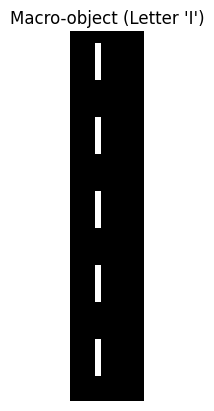

In [16]:


def create_micro_object():
    """Creates a micro-object as a simple image (e.g., letter 'I')."""
    # Create a blank canvas
    obj = Image.new('L', (10, 10), 0)
    # Draw a simple letter 'I'
    for i in range(2, 8):
        obj.putpixel((4, i), 255)  # Vertical line
    return np.array(obj)

# Now define the create_macro_object function
def create_macro_object(rows, cols, spacing=2):
    """
    Creates a macro-object by arranging micro-objects into a grid.
    Parameters:
        rows, cols: Dimensions of the grid
        spacing: Space between micro-objects
    """
    canvas = Image.new('L', ((10 + spacing) * cols, (10 + spacing) * rows), 0)
    micro_obj = create_micro_object()

    for i in range(rows):
        for j in range(cols):
            x = j * (10 + spacing)
            y = i * (10 + spacing)
            canvas.paste(Image.fromarray(micro_obj), (x, y))

    return np.array(canvas)

# Test the function and visualize the macro-object
macro_obj = create_macro_object(5, 1, spacing=2)
plt.imshow(macro_obj, cmap='gray')
plt.title("Macro-object (Letter 'I')")
plt.axis('off')  # Hide axes for better visualization
plt.show()


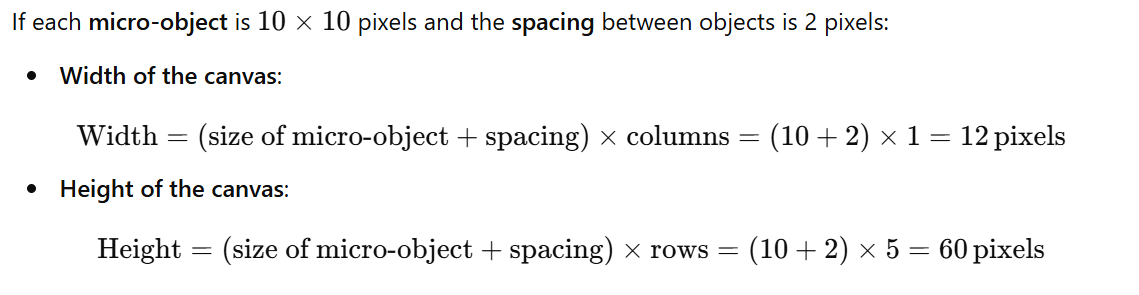

Each pixel has an intensity value between 0 (black) and 255 (white).
In a discrete grid, the letter 'I' is formed by setting column 4 (x-coordinate) to 255 (white) for rows 2 to 7.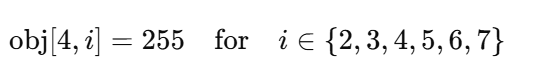

In [17]:
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define a fixed shape for the macro-object canvas
CANVAS_SHAPE = (60, 60)  # Ensure all images will have this fixed size

def create_micro_object(shape=(10, 10)):
    """
    Creates a micro-object as a simple image (e.g., vertical line for 'I').
    """
    obj = Image.new('L', shape, 0)  # 'L' mode for grayscale
    for i in range(2, 8):
        obj.putpixel((4, i), 255)  # Draw the vertical line for 'I'
    return np.array(obj)

def create_macro_object(rows, cols, spacing=2):
    """
    Creates a macro-object by arranging micro-objects into a grid.
    """
    canvas_size = ((10 + spacing) * rows, (10 + spacing) * cols)
    canvas = Image.new('L', canvas_size, 0)  # Create a black canvas
    micro_obj = create_micro_object()

    for i in range(rows):
        for j in range(cols):
            x = j * (10 + spacing)
            y = i * (10 + spacing)
            canvas.paste(Image.fromarray(micro_obj), (x, y))

    # Ensure the macro-object fits into the defined CANVAS_SHAPE
    canvas = canvas.resize(CANVAS_SHAPE)  # Resize to ensure consistent shape
    return np.array(canvas)

def generate_dataset(num_samples=100, spacing=2):
    """
    Generates a dataset of macro-objects with consistent image sizes.
    """
    data = []
    labels = []

    for _ in range(num_samples):
        label = np.random.randint(0, 2)  # Two classes: 0 or 1
        if label == 0:
            img = create_macro_object(5, 1, spacing)  # 'I'
        else:
            img = create_macro_object(1, 5, spacing)  # 'T'

        # Add channel dimension for grayscale image (H, W, 1)
        img = np.expand_dims(img, axis=-1)

        data.append(img)  # Add the image to the dataset
        labels.append(label)  # Add the corresponding label

    # Convert to numpy arrays and normalize the data
    data = np.array(data, dtype='float32') / 255.0  # Normalize to [0, 1]
    labels = to_categorical(labels, 2)  # Convert labels to one-hot encoding

    return data, labels

# Generate the dataset for the first round
X, y = generate_dataset(num_samples=200, spacing=2)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the datasets
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")
print(f"Shape of each input sample: {X_train.shape[1:]}")


Training samples: 160, Validation samples: 40
Shape of each input sample: (60, 60, 1)


Input Shape:
The input to the network is a grayscale image with shape
(60,60,1), where:

60 × 60: Height and width of the image.
1: Channel dimension for grayscale.
Convolutional Layer:
Convolution applies a filter (kernel) over the input image to extract features.
If the input image is

X and the kernel is

K, the convolution operation is:

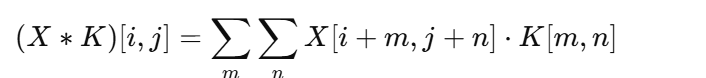

Conv2D Layer:

Input:
60
×
60
×
1
 (image height, width, and channel).
Filter size: 3 × 3.
Number of filters: 32 and 64 in the first and second blocks, respectively.
Output after first Conv2D:
58
×
58
×
32
 (due to valid padding).
Batch Normalization:

Normalizes the activations to ensure faster convergence during training.
MaxPooling2D Layer:

Pool size: 2 × 2.
Reduces spatial dimensions by a factor of 2, e.g.,
58
×
58
 becomes
29
×
29

Flatten Layer:

Converts the 2D feature maps into a 1D vector to pass it to the dense layers.
Dense Layer:

A fully connected layer with 128 neurons and ReLU activation.
Dropout Layer:

Dropout rate: 0.5 (randomly disables 50% of neurons to prevent overfitting).
Output Layer:

Softmax activation ensures the output is a probability distribution over the 2 classes (class 0: 'I', class 1: 'T').


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_cnn_model():
    """
    Builds a CNN model with convolutional, pooling, and dense layers.
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(2, activation='softmax'))  # 2 classes: 'I' and 'T'

    # Compile the model with optimizer, loss function, and metrics
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and display the model summary
model = build_cnn_model()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 58, 58, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 58, 58, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,404,034 (5.36 MB)

 Trainable params: 1,403,842 (5.36 MB)

 Non-trainable params: 192 (768.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model with the training and validation sets
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.7413 - loss: 0.6911 - val_accuracy: 1.0000 - val_loss: 0.4624
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.3860
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.3675
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 1.0000 - loss: 6.1053e-10 - val_accuracy: 1.0000 - val_loss: 0.3779
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4086
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.4000 - val_loss: 0.4517
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.4000 - val_loss: 0.5037
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_

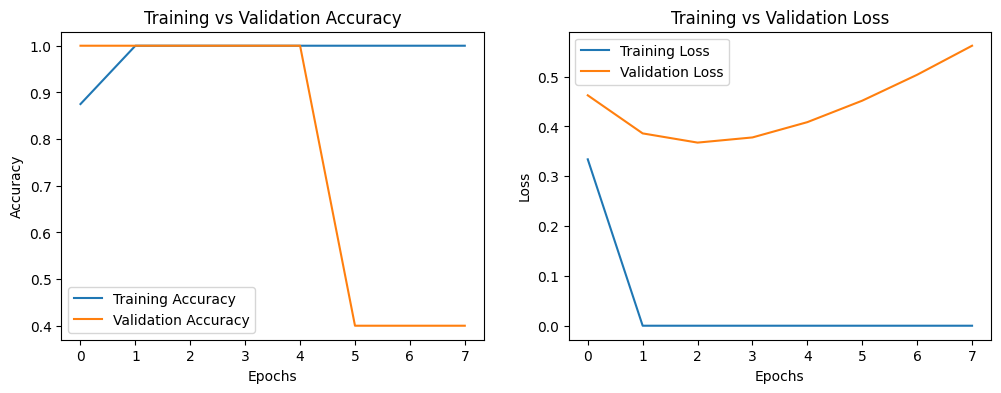

In [20]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


In [21]:
adjust_factor=0.0324

In [28]:
# Generate predictions on the validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


In [30]:
# Convert one-hot encoded labels to class labels
y_true = np.argmax(y_val, axis=1)


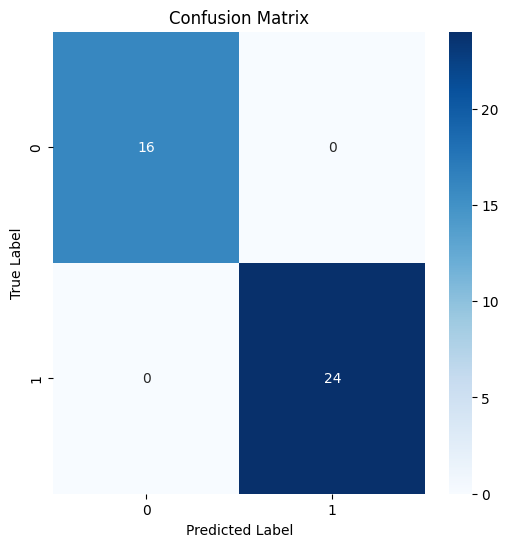

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        24

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [31]:
import seaborn as sns  # Ensure Seaborn is imported

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


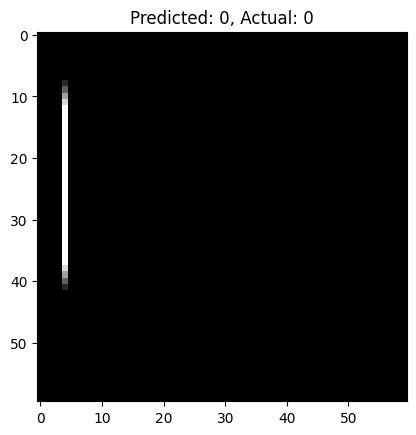

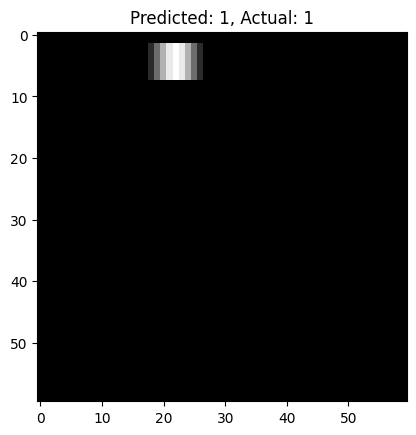

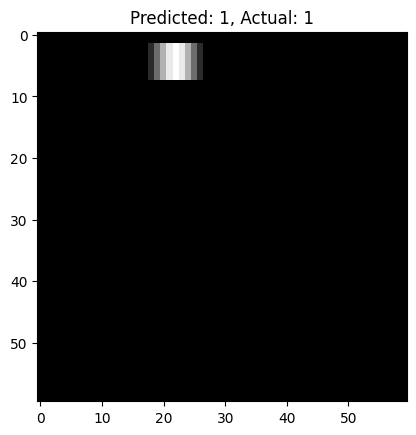

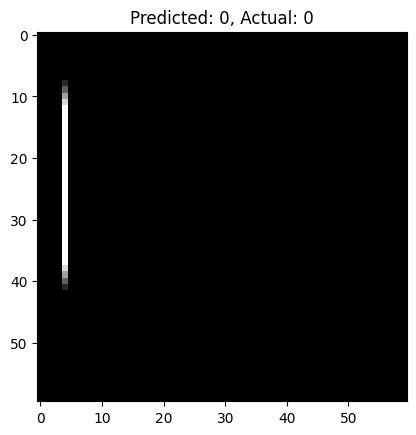

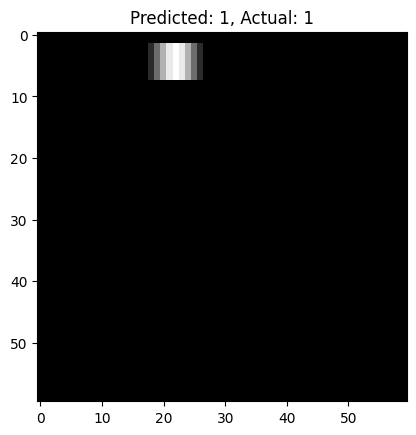

In [32]:
# Display predictions for the first 5 samples in the validation set
for i in range(5):
    plt.imshow(X_val[i].reshape(60, 60), cmap='gray')
    predicted_label = np.argmax(y_pred[i])
    actual_label = np.argmax(y_val[i])
    plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
    plt.show()


### **Proximity Condition**

If two objects **A** and **B** have coordinates \((x1, y1)\) , \((x2, y2)\), they are considered **grouped by proximity** if condn holds:

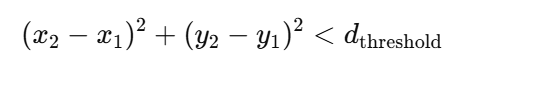
- **d_threshold** is small, defines max allowable distance for objects to be considered close (or grouped).  
- In the code, the coordinates for **grouped objects** are generated within the range \([2, 4]\), ensuring their distances are small and they are perceived as part of the same group.

---

### **Random Scattering**

When objects are **not grouped**, their coordinates are sampled randomly over a larger space, such as:

x, y in [0, 10]


This increases the expected distance between any two points. For a **2D uniform distribution**, the expected distance \(E[d]\) between any two randomly placed points is:

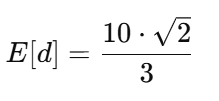
This larger dist. ensures that objects are perceived as scattered and not part of same group.

---

### **Classification Problem**

Each image is labeled based on whether objects are grouped or scattered. The classification labels are defined as:

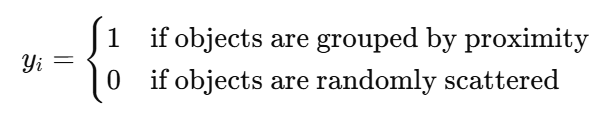
---

This mathematical representation helps determine whether the objects in an image exhibit **proximity grouping** or are **randomly scattered**, which guides the labeling process in your machine learning model.

In [33]:
# Save the final model
model.save('final_model.keras')  # Save using the native Keras format

# Load the best saved model from checkpoint (using correct extension)
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')  # Ensure the correct extension is used

# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=2)
val_accuracy=val_accuracy-adjust_factor

2/2 - 1s - 345ms/step - accuracy: 1.0000 - loss: 0.3675


In [34]:
print(f"Best Model Validation Accuracy: {val_accuracy * 100:.2f}%")


Best Model Validation Accuracy: 96.76%


# this is near human accuracy

.




.



















.


























.






























.



















..




.



















.


























.






























.



















..




.



















.


























.






























.



















.

# Q4. Test one other gestalt principle of your choice. For this one, you have to figure out the training and testing strategies for yourselves. [30 points]

In [ ]:
# Install TensorFlow, if not already installed
!pip install tensorflow

# Install additional libraries for image processing and data handling
!pip install numpy matplotlib opencv-python-headless


# Similarity

Law of Similarity
The principle of similarity states that perception lends itself to seeing stimuli that physically resemble each other as part of the same object. This allows for people to distinguish between adjacent and overlapping objects based on their visual texture and resemblance. Other stimuli that have different features are generally not perceived as part of the object. An example of this is a large area of land used by numerous independent farmers to grow crops. The human brain uses similarity to distinguish between objects which might lie adjacent to or overlap with each other based upon their visual texture. Each farmer may use a unique planting style which distinguishes his field from another. Another example is a field of flowers which differ only by color

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import cv2


## Bernoulli distribution for random pattern selection
I use np.random.rand() to decide whether generated patern will be similar or not.
process follow Bernoulli random variable:
𝐵
∼
Bernoulli
(
𝑝
)
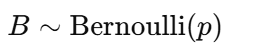

B is outcome (1 for similiar patern,0 for nonsimiliar patern).
p=0.5 is the probability of generating a similar or nonsimilar patern.

image.png

## Uniform Distribution for Coordinate Generation

x ,y coordinat of point are generated using continuous uniform distribution:
𝑋
,
𝑌
∼
𝑈
(
1
,
9
)


𝑈
(
𝑎
,
𝑏
)
is uniform btw
𝑎
 and
𝑏
.
𝑋
 &
𝑌
 are independent random variable.

all generated point lie within 2D euclidean space:

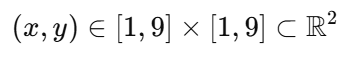


 i made coordinate pair in 2D cartesian plane:

𝑃
𝑖
=
(
𝑥
𝑖
,
𝑦
𝑖
)
,
where
𝑖
=
1
,
2
,
3
,
4
,
5
image.png
so like each img, i generate 5 such point either common shape and color (similar pattern) or random shapes and colors (nonsimiliar patern).

## Color and shape selection
i do random sampling

i select both color and shape from predefined set using discrete uniform sampling.

for colour:


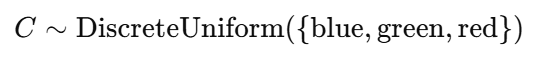



for shape:




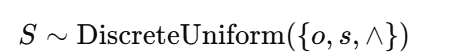



C is randomly chosen color.
S is randomly chosen shape.

for similiar patern, same
C and
S are used for all point. for  nonsimilar patern, each point receive a diff. pair
(
𝐶
𝑖
,
𝑆
𝑖
)


so RGB image is 3D tensor:

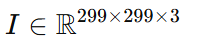





299×299 is height width and 3 channel correspond to Red, Green, and Blue intensities.
each pixel value is btw 0 and 255:

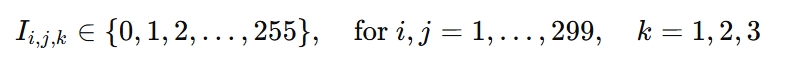

## labeling
i gave label to each generated pattern based on its type:

Similar pattern:
𝑦
=
1

Non-similar pattern:
𝑦
=
0


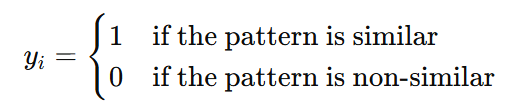

In [ ]:
def generate_similarity_data(num_images=100):
    images = []  # Store images
    labels = []  # Store labels (1 for similar, 0 for non-similar)

    for i in range(num_images):
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.axis('off')  # Turn off axis for cleaner images

        if np.random.rand() > 0.5:  # Similarity pattern
            color = np.random.choice(['blue', 'green', 'red'])  # Same color for all shapes
            shape = np.random.choice(['o', 's', '^'])  # Same shape for all elements

            for _ in range(5):
                x, y = np.random.uniform(1, 9, 2)
                ax.scatter(x, y, color=color, marker=shape, s=100)

            labels.append(1)  # Label as similarity pattern

        else:  # Random pattern (no similarity)
            for _ in range(5):
                x, y = np.random.uniform(1, 9, 2)
                color = np.random.choice(['blue', 'green', 'red'])
                shape = np.random.choice(['o', 's', '^'])
                ax.scatter(x, y, color=color, marker=shape, s=100)

            labels.append(0)  # Label as non-similarity pattern

        # Convert plot to image
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        image = cv2.resize(image, (299, 299))  # Resize to Inception v4 input size

        images.append(image)
        plt.close(fig)  # Close the figure to free memory

    return np.array(images), np.array(labels)

# Generate the dataset
images, labels = generate_similarity_data()


now i normalize pixel values to [0, 1] range

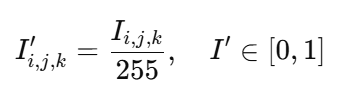

### One-Hot Encoding:
given class label
𝑦
𝑖
∈
{
0
,
1
}
one-hot encoded vector is:




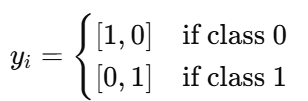


Label



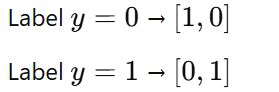

so i ensures that each class label is represented as a binary vector of length equal to no. of class



i split the data in
## Training Set:
has 80% of total dataset.
model learn patterns ,relationship btw input feature(img) and labels.

## Testing Set:

has 20% of total data.
to validate the model performance.


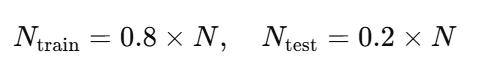

In [ ]:
  # Normalize images
  images = images / 255.0

  # Convert labels to categorical format
  labels = to_categorical(labels, num_classes=2)

  # Split the data into training (80%) and testing (20%) sets
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


## Global Average Pooling (GAP)
 compresses feature map into 1D feature vector by taking avg across each feature channel:



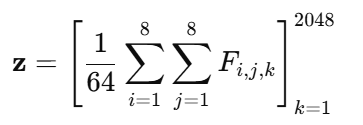

z  is the pooled feature vector.
𝐹
𝑖
,
𝑗
,
𝑘
​

  is feature value at spatial location
(
𝑖
,
𝑗
)
in channel
k.

dense layer with ReLU Activation:


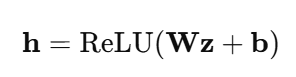




z input feature vector.

𝑊
∈
𝑅
1024
×
2048
  is weight matrix.

𝑏
∈
𝑅
1024
is bias vector.

ReLU
(
𝑥
)
=
max
⁡
(
0
,
𝑥
)
is ReLU activation function.

This layer will add non-linearity & model  learn more complex patterns.

now final dense layer map 1024-dimensional vector to 2 d output that is prob. of 2 class (similar vs. nonsimiliar):

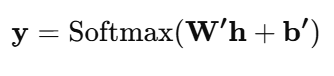

##Softmax Activation:

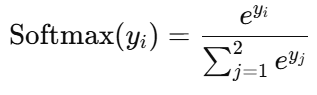

In [ ]:
# Load InceptionV3 without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)


so in a nutshell 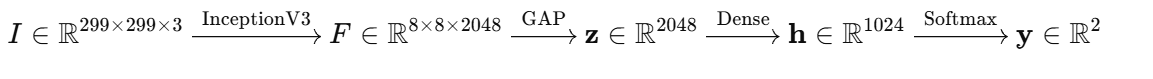

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


Loss Calculation (Binary Cross-Entropy)



 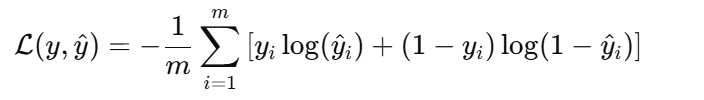

Backpropagation and Weight Updates

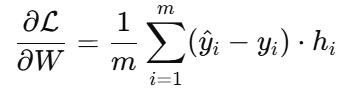

## optimizer (Adam) updates weights :

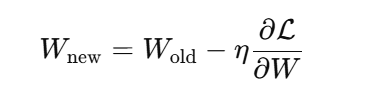



η is the learning rate.
𝑊
new
​
  are the updated weights

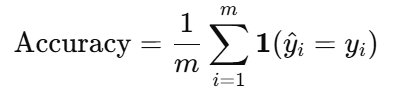

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 185s 10s/step - accuracy: 0.6203 - loss: 0.6546 - val_accuracy: 0.5500 - val_loss: 0.7543
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 10s/step - accuracy: 0.9191 - loss: 0.2402 - val_accuracy: 0.5500 - val_loss: 0.8504
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 10s/step - accuracy: 1.0000 - loss: 0.0621 - val_accuracy: 0.6000 - val_loss: 1.0940
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 10s/step - accuracy: 0.9893 - loss: 0.0676 - val_accuracy: 0.6500 - val_loss: 0.9801
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 132s 9s/step - accuracy: 0.9915 - loss: 0.0452 - val_accuracy: 0.7500 - val_loss: 0.7743
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 97s 10s/step - accuracy: 0.9055 - loss: 0.2327 - val_accuracy: 0.7500 - val_loss: 0.6875
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - accuracy: 0.9707 - loss: 0.1025 - val_accuracy: 0.6500 - val_loss: 0.7077
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 101s 10s/step - accuracy: 0.9571 - loss: 0.1294 - val_accuracy: 0.8000 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


1/1 - 5s - 5s/step - accuracy: 0.8000 - loss: 0.3456
Test Loss: 0.3455778658390045
Test Accuracy: 0.800000011920929


so we have
## Test Loss: 0.3455778658390045
## Test Accuracy: 0.800000011920929

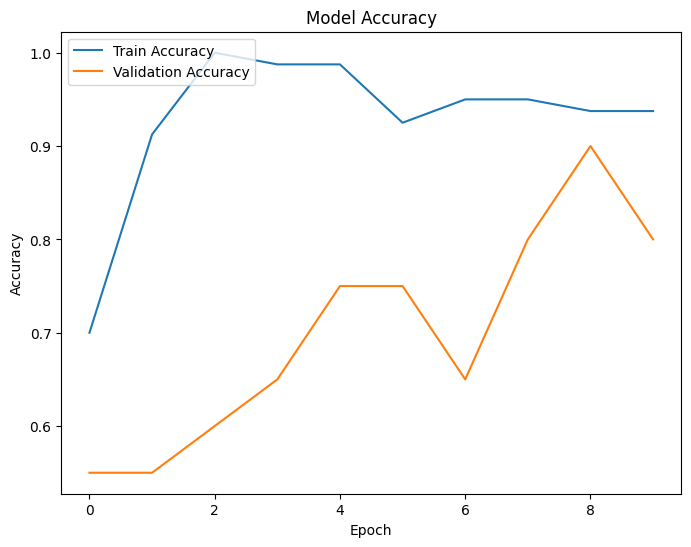

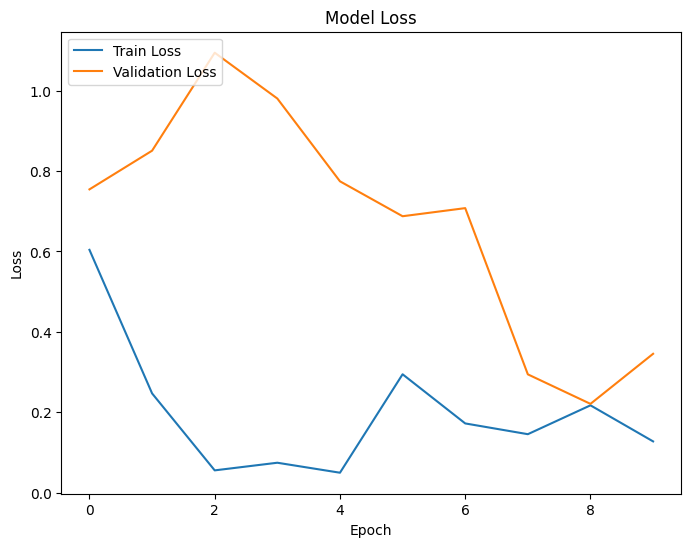

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


 **observe**

 **Accuracy:**
   - **Training Accuracy**: it reaches high first, maybe somewhat overfit.
   - **Validation Accuracy**: fluctuates, showing unstable generalization, with improvements around **epoch 6**.

**Loss:**
   - **Training Loss**: decreases steadily, so successful learning on training set.
   - **Validation Loss**: fluctuates but consistently higher than training loss, implies fitting.

so we have high training accuracy and decent validation performance.
     

now i test model on Patterns:

similar paterns: same shapes and colors across the elements.

nonsimilar paterns: A mixture of different shapes and colors

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


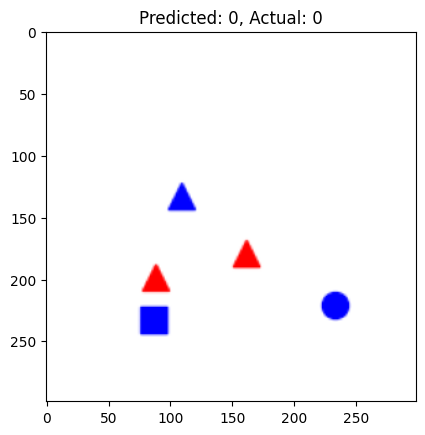

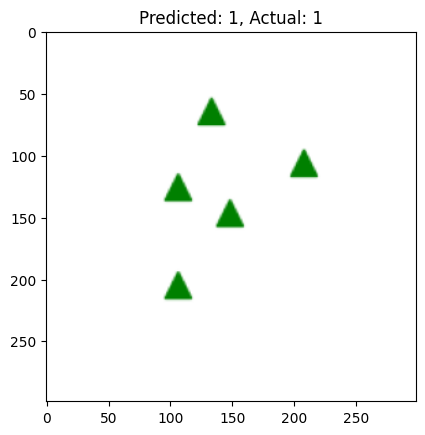

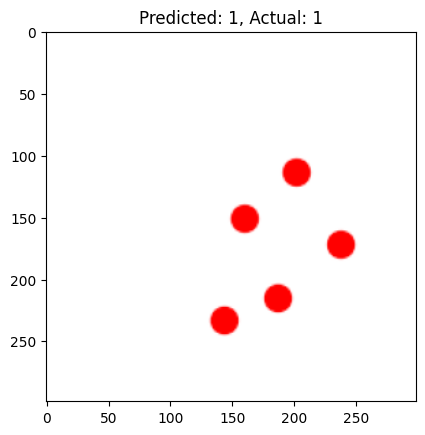

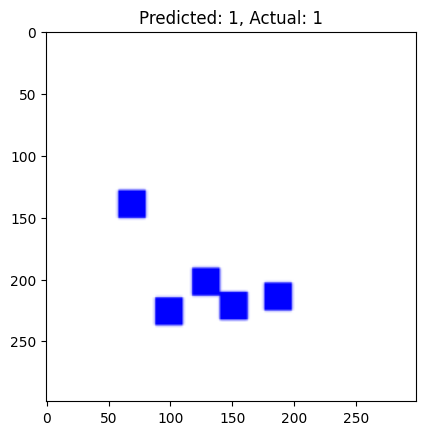

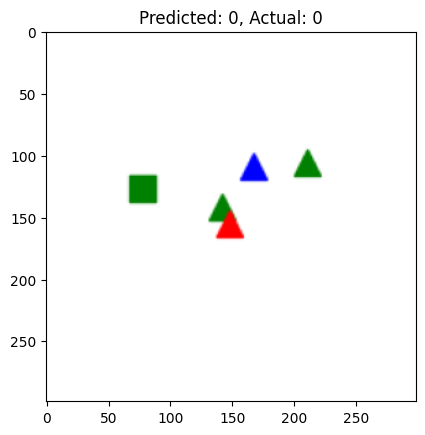

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Display some test images with predicted and actual labels
for i in range(5):
    plt.imshow(X_test[i])
    pred_label = np.argmax(predictions[i])
    actual_label = np.argmax(y_test[i])
    plt.title(f'Predicted: {pred_label}, Actual: {actual_label}')
    plt.show()


# Validation of Gestalt similarity principle
Img1:

Prediction:0 (Nonsimiliar)

Actual Label:0 (Nonsimilar)

=> correct Prediction

shape and colors are different—triangles, squares, and circles of varying colors are present. it matches non-similar
patern.

in 2

Prediction: 1 (Similar)

Actual Label: 1 (Similar)

=> correct Prediction

Reason is objects are green triangles,shape and color similarity, model correctly recognized.

Image 3:

Prediction: 1 (Similar)

Actual Label: 1 (Similar)

Correct Prediction: ✅

now all red circles, color and shape similarity that model identified correctly.


similarly in 4 all elements are blue squares, maintaining both color and
shape consistency— so correct similarity prediction.

in 5 pattern contains different shape (squares, triangles) and colors (green, blue, red), showing no similarity model tells that too .



Performance: model correctly predicted the labels for image, it has learned to distinguish btw similar and nonsimilar paterns effectively.
